In [1]:
# Built-in
import sys
import os
import math
import itertools
import multiprocessing

# Analysis packages
import scanpy as sc
import anndata as ad
from adpbulk import ADPBulk
import numpy as np
import pandas as pd
import memento
from statsmodels.compat import lzip
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy import stats
from sklearn.decomposition import PCA
from sklearn import manifold
import h5py

# Plotting packages
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.patheffects as path_effects
from pathlib import Path
import seaborn as sns
from adjustText import adjust_text

# Set number of cores to use
sc.settings.n_jobs = 8

sc.logging.print_header()

scanpy==1.10.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.0 scipy==1.13.1 pandas==1.5.3 scikit-learn==1.5.0 statsmodels==0.13.5 igraph==0.11.6 pynndescent==0.5.8


In [2]:
pd.set_option('display.max_columns', 40)

In [3]:
# Set autoreload settings. With this code,
# changing settings.py (see next cell) automatically loads the new settings in here too.
%load_ext autoreload
%autoreload 1

# Modify settings from this file (figure path, subsetting settings, etc)
# The file is located in this directory (settings.py)
%aimport settings

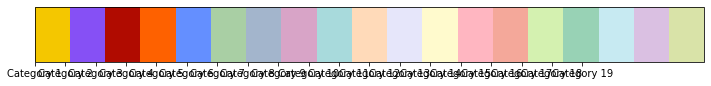

In [4]:
# Define the extended color list
colors_19 = [
    "#F4C700", "#8650F5", "#B00B00", "#FE6100", "#648FFF",
    "#A9CFA4", "#A3B5CC", "#D8A4C7", "#A8DADC", "#FFDAB9",
    "#E6E6FA", "#FFFACD", "#FFB6C1", "#F4A89A", "#D4F1B0",
    "#98D2B5", "#C7EAF2", "#DAC0E2", "#D9E3A8",
]

# Create a ListedColormap
custom_cmap = ListedColormap(colors_19)

# Display the colormap using a colorbar
fig, ax = plt.subplots(figsize=(12, 2))
fig.subplots_adjust(bottom=0.5)

# Create a colorbar with the custom cmap
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=custom_cmap), 
    cax=ax, orientation='horizontal', ticks=[]
)

# Use the colors as category labels
cbar.set_ticks([i / 22.0 for i in range(len(colors_19))])
cbar.set_ticklabels([f'Category {i + 1}' for i in range(len(colors_19))])

# Display the colorbar
plt.show()

# Overhead

In [5]:
def extend_limits(t, buffer=0.02):
    lower = t[0]
    upper = t[1]
    extension = buffer * (upper - lower)
    return (lower - extension, upper + extension)
extend_limits((0,2))

(-0.04, 2.04)

In [6]:
adata = sc.read("post-wt-clustering-with-markers.h5ad")
adata

AnnData object with n_obs × n_vars = 264420 × 24181
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'leiden', 'id', 'name', 'color'
    var: 'gene_name', 'gene_ids', 'feature_types', 'genome', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_leiden', 'hvg', 'label_colors', 'label_colors_dict', 'label_order', 'log1p', 'name_colors', 'rank_genes_groups', 'scrublet', 'stage_colors_dict', 'stage_order'
    obsm: 'X_pca', 'X_umap'
    layers: 'ds_norm_cts', 'raw-cts_pre-ds'
    obsp: 'connectivities', 'distances'

In [7]:
dendro_ordered_cluster_ids = adata.uns['dendrogram_leiden']['categories_ordered']

In [8]:
drugs = ["none", "Ket", "Psilo"]
times = adata.uns["stage_order"]
clusters = ['0','1','2','3','4','5','6','7','8','9','10','12']
cluster_names = ['L2/3-IT','L6-CT','L4/5-IT','L4-IT',
                 'Oligodendrocytes','L5/6-IT','Astrocytes','L5-PT','CIN-PV',
                 'OPC','CIN-SST','CIN-VIP']

In [9]:
trt_drugs = drugs[1:]
trt_times = times[1:]

In [10]:
cluster_lookup = pd.DataFrame({'id':clusters, 'name':cluster_names})
cluster_lookup['id'] = pd.Categorical(cluster_lookup['id'], categories=dendro_ordered_cluster_ids, ordered=True)
cluster_lookup = cluster_lookup.sort_values('id')
cluster_lookup['name'] = pd.Categorical(cluster_lookup['name'], categories=cluster_lookup['name'], ordered=True)
cluster_lookup['color'] = adata.uns['name_colors']
cluster_lookup

id              name    color
1    1             L6-CT  #A9CFA4
7    7             L5-PT  #F4C700
2    2           L4/5-IT  #8650F5
3    3             L4-IT  #4F19BE
0    0           L2/3-IT  #7662A0
5    5           L5/6-IT  #BA98FF
11  12           CIN-VIP  #648FFF
8    8            CIN-PV  #B00B00
10  10           CIN-SST  #FE6100
4    4  Oligodendrocytes  #A3B5CC
6    6        Astrocytes  #D8A4C7
9    9               OPC  #A8DADC

In [11]:
# 4 shades of pruple
cluster_lookup.loc[2,'color'] = '#8650F5'
cluster_lookup.loc[3,'color'] = '#4F19BE'
cluster_lookup.loc[0,'color'] = '#7662A0'
cluster_lookup.loc[5,'color'] = '#BA98FF'

In [12]:
# dropped_cluster_lookup = pd.DataFrame({'id':[11,13,14,15,16,17,18,19,20,21], 'name':np.nan, 'color':colors_19[9:]})
dropped_cluster_lookup = pd.DataFrame({'id':[11,13,14,15,16,17,18,19,20,21], 'name':np.nan, 'color':'lightgrey'})
dropped_cluster_lookup['id'] = dropped_cluster_lookup['id'].astype(str)
all_cluster_lookup = pd.concat([cluster_lookup, dropped_cluster_lookup]).reset_index(drop=True)
all_cluster_lookup

id              name      color
0    1             L6-CT    #A9CFA4
1    7             L5-PT    #F4C700
2    2           L4/5-IT    #8650F5
3    3             L4-IT    #4F19BE
4    0           L2/3-IT    #7662A0
5    5           L5/6-IT    #BA98FF
6   12           CIN-VIP    #648FFF
7    8            CIN-PV    #B00B00
8   10           CIN-SST    #FE6100
9    4  Oligodendrocytes    #A3B5CC
10   6        Astrocytes    #D8A4C7
11   9               OPC    #A8DADC
12  11               NaN  lightgrey
13  13               NaN  lightgrey
14  14               NaN  lightgrey
15  15               NaN  lightgrey
16  16               NaN  lightgrey
17  17               NaN  lightgrey
18  18               NaN  lightgrey
19  19               NaN  lightgrey
20  20               NaN  lightgrey
21  21               NaN  lightgrey

In [13]:
rna_data = adata.copy()
rna_data.X = rna_data.layers['raw-cts_pre-ds'].copy()

# Figure 1C (formerly 1)

Create the homepage plot from SC Cluster Expression

In [14]:
this_figure_dir = f'{settings.fig_path}/figure_1c'
os.makedirs(this_figure_dir, exist_ok=True)

In [15]:
# Read h5 data
csc_data_path = '/nfs/turbo/umms-kykwan/projects/alex_kwan/figures/scanpy_cellranger_fixed_sex/gold-sc-cluster-expression.h5ad'
f = h5py.File(csc_data_path, 'r')

In [16]:
# LABEL_COLORS = f['uns/label_colors'][:].astype(str)
gene_index = list(f['var/gene_name'][:].astype(str))
SORTED_GENE_LIST = sorted(gene_index)
INDPTR = f['X']['indptr']

In [17]:
def column_from_codes_and_cats(group_name, desired_type):
    codes = f[f'obs/{group_name}/codes'][:]
    categories = f[f'obs/{group_name}/categories'][:]
    return pd.Categorical(values=codes).rename_categories(categories).to_numpy().astype(desired_type)

In [18]:
time = f['obs/time'][:]
drug = column_from_codes_and_cats('drug', 'str')
sex = column_from_codes_and_cats('sex', 'str')
leiden = column_from_codes_and_cats('leiden', 'str')
umap_coords = f['obsm/X_umap'][:]

cell_metadata = pd.DataFrame()
cell_metadata['time'] = time
cell_metadata['sex'] = sex
cell_metadata['drug'] = drug
cell_metadata['leiden'] = leiden
cell_metadata['umap_x'] = umap_coords[:,0]
cell_metadata['umap_y'] = umap_coords[:,1]

cell_metadata = cell_metadata.merge(all_cluster_lookup, how='left', left_on='leiden', right_on='id')
cell_metadata['color'] = cell_metadata['color'].fillna('lightgrey')

In [19]:
cell_metadata

time sex  drug leiden     umap_x     umap_y  id              name  \
0          0   F  none      1  15.010727   0.330866   1             L6-CT   
1          0   F  none      8  17.109165   5.809040   8            CIN-PV   
2          0   F  none     11   5.041676   4.268663  11               NaN   
3          0   F  none      0   9.738292  13.889116   0           L2/3-IT   
4          0   F  none     13  -3.909645   8.076061  13               NaN   
...      ...  ..   ...    ...        ...        ...  ..               ...   
299188    72   M   Ket      0   8.451635  13.046877   0           L2/3-IT   
299189    72   M   Ket      4   1.930006  -4.309301   4  Oligodendrocytes   
299190    72   M   Ket      4   0.143202  -3.496105   4  Oligodendrocytes   
299191    72   M   Ket      1  16.393003   0.459176   1             L6-CT   
299192    72   M   Ket      3  12.519709   9.848543   3             L4-IT   

            color  
0         #A9CFA4  
1         #B00B00  
2       lightgrey  
3         #7662A0  
4       lightgrey  
...           ...  
299188    #7662A0  
299189    #A3B5CC  
299190    #A3B5CC  
299191    #A9CFA4  
299192    #4F19BE  

[299193 rows x 9 columns]

In [20]:
def get_sorted_observations(gene_name):
    col_idx = gene_index.index(gene_name)
    X_data = f['X/data'][INDPTR[col_idx] : INDPTR[col_idx+1]]
    X_data = X_data
    X_indices = f['X/indices'][INDPTR[col_idx] : INDPTR[col_idx+1]]
    sorted_obs = cell_metadata.copy()
    sorted_obs['expression'] = 0
    sorted_obs.loc[X_indices, 'expression'] = X_data
    sorted_obs = sorted_obs.sort_values('expression')
    return sorted_obs

/tmp/ipykernel_3427694/135711746.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


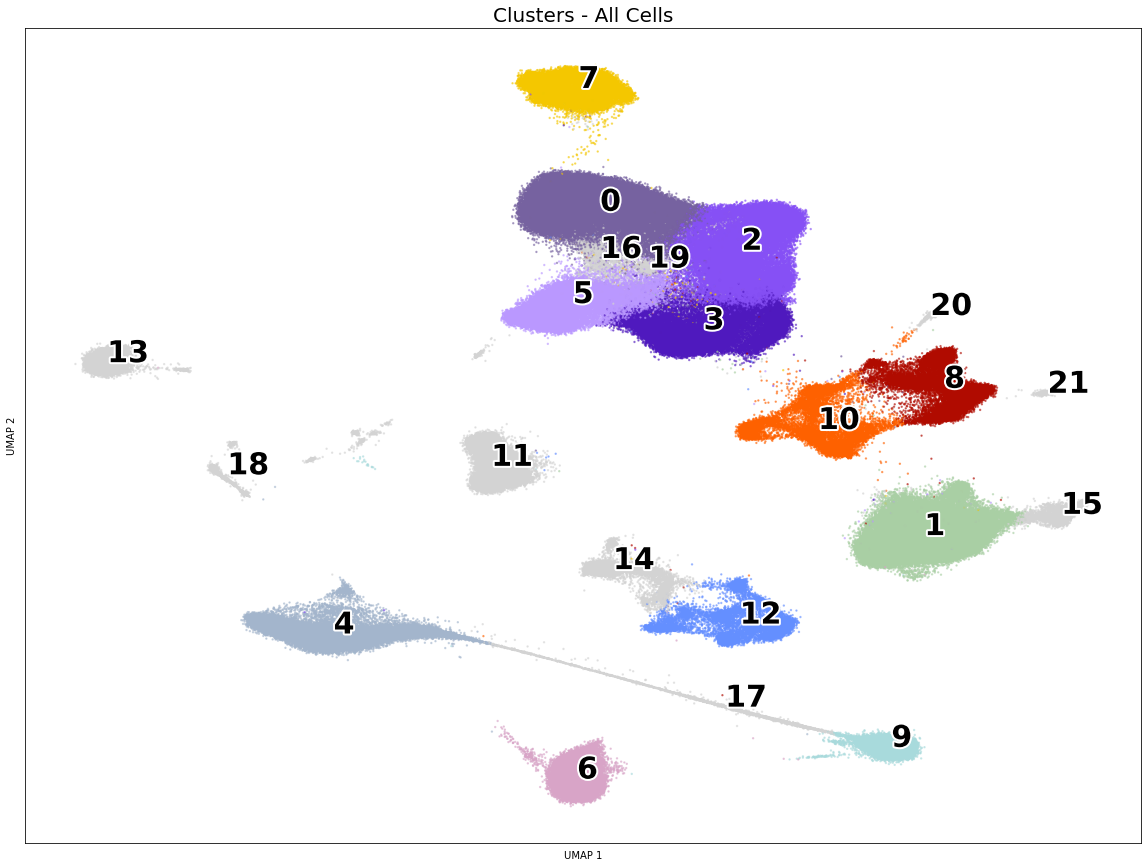

In [26]:
def manage_cluster_subplot(ax, cell_metadata, label_clusters=True):
#     colors = { idx:col for idx,col in enumerate(LABEL_COLORS) }
    ax.scatter(
        x=cell_metadata['umap_x'], y=cell_metadata['umap_y'], 
        # c=cell_metadata['leiden'].map(colors), 
        c=cell_metadata['color'],
        alpha=0.5, s=2
    )
    ax.set(
        xlabel='UMAP 1', ylabel='UMAP 2', 
        xticks=[], yticks=[],
    )
    ax.set_title('Clusters - All Cells', fontsize=20)
    cluster_label_df = cell_metadata.groupby('leiden')[['umap_x','umap_y']].agg(pd.Series.median)
    if label_clusters == True:
        for label, coords in cluster_label_df.iterrows():
            text = ax.annotate(
                label, 
                xy=(coords['umap_x'], coords['umap_y']), xycoords='data',
                fontsize=30,
                weight='bold'
            )
            text.set_path_effects([path_effects.Stroke(linewidth=4, foreground='white'),
                           path_effects.Normal()])

fig, ax = plt.subplots(1, 1, figsize=(20,15))
manage_cluster_subplot(ax=ax, cell_metadata=cell_metadata, label_clusters=False)
fig.savefig(f'{this_figure_dir}/all_cells_no_labels.png', bbox_inches="tight")
fig.savefig(f'{this_figure_dir}/all_cells_no_labels.pdf', bbox_inches="tight")
plt.close()

fig, ax = plt.subplots(1, 1, figsize=(20,15))
manage_cluster_subplot(ax=ax, cell_metadata=cell_metadata, label_clusters=True)
fig.savefig(f'{this_figure_dir}/all_cells_cluster_labels.png', bbox_inches="tight")
fig.savefig(f'{this_figure_dir}/all_cells_cluster_labels.pdf', bbox_inches="tight")
fig.show()

## Seperate drugs

no labels - these can be imported from the other plots

/tmp/ipykernel_1210958/810934979.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_1210958/810934979.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


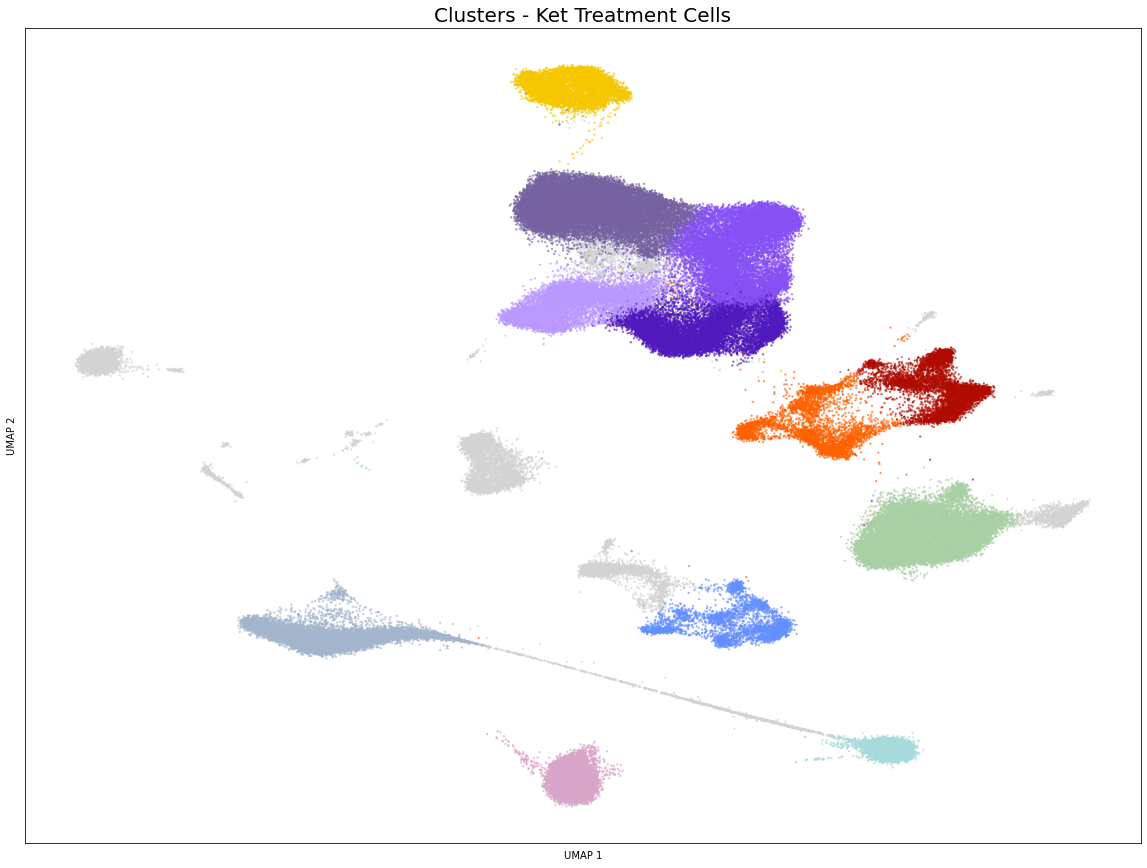

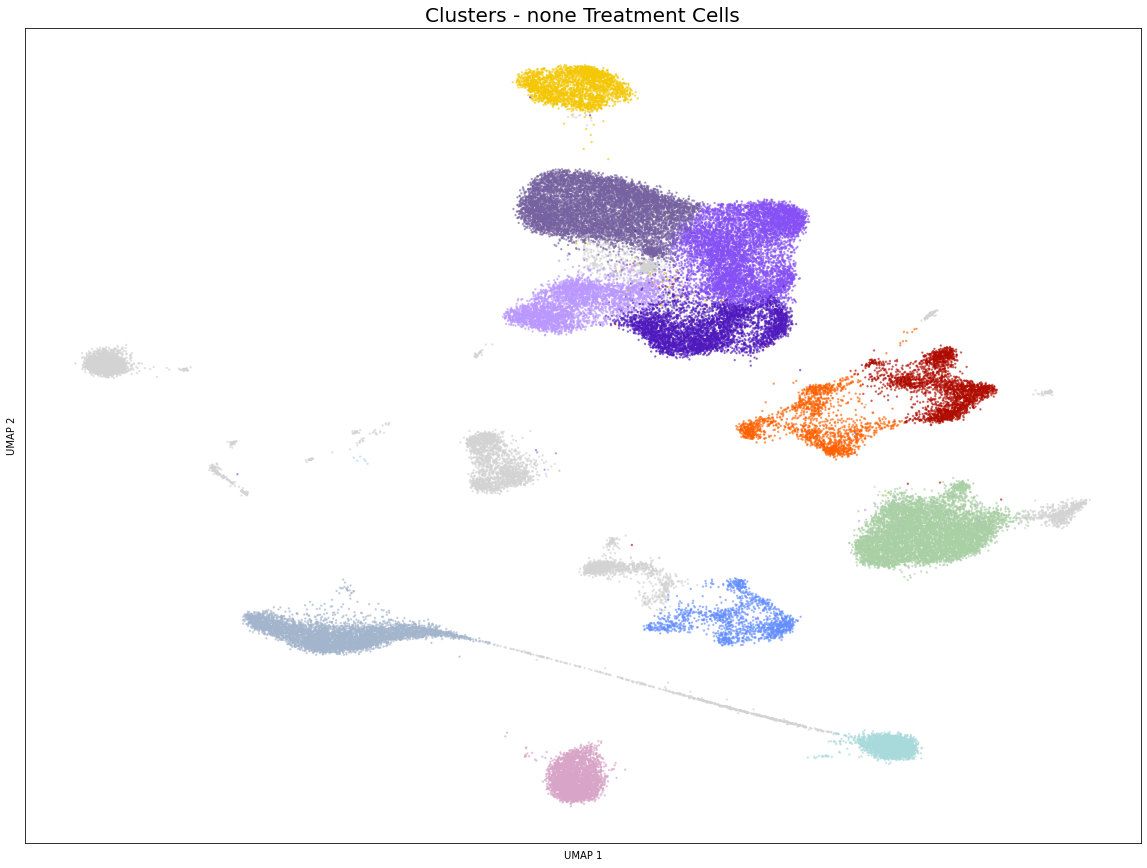

In [21]:
def manage_drug_seperate_cluster_subplot(ax, cell_metadata, drug):
#     colors = { idx:col for idx,col in enumerate(LABEL_COLORS) }
#     ax.scatter(
#         x=cell_metadata['umap_x'], y=cell_metadata['umap_y'], 
#         c='lightgrey', alpha=0.7, s=4
#     )
    
    this_drug_cell_metadata = cell_metadata[cell_metadata['drug'] == drug]
    ax.scatter(
        x=this_drug_cell_metadata['umap_x'], y=this_drug_cell_metadata['umap_y'], 
        c=this_drug_cell_metadata['color'], 
        alpha=0.5, s=2
    )
    
    ax.set(
        xlabel='UMAP 1', ylabel='UMAP 2', 
        xticks=[], yticks=[],
    )
    ax.set_title(f'Clusters - {drug} Treatment Cells', fontsize=20)
    cluster_label_df = cell_metadata.groupby('leiden')[['umap_x','umap_y']].agg(pd.Series.median)


fig, ax = plt.subplots(1, 1, figsize=(20,15))
manage_drug_seperate_cluster_subplot(ax=ax, cell_metadata=cell_metadata, drug='Psilo')
fig.savefig(f'{this_figure_dir}/psilo_cells_no_labels.png', bbox_inches="tight")
fig.savefig(f'{this_figure_dir}/psilo_cells_no_labels.pdf', bbox_inches="tight")
plt.close()

fig, ax = plt.subplots(1, 1, figsize=(20,15))
manage_drug_seperate_cluster_subplot(ax=ax, cell_metadata=cell_metadata, drug='Ket')
fig.savefig(f'{this_figure_dir}/ket_cells_no_labels.png', bbox_inches="tight")
fig.savefig(f'{this_figure_dir}/ket_cells_no_labels.pdf', bbox_inches="tight")
plt.close()

fig, ax = plt.subplots(1, 1, figsize=(20,15))
manage_drug_seperate_cluster_subplot(ax=ax, cell_metadata=cell_metadata, drug='none')
fig.savefig(f'{this_figure_dir}/nodrug_cells_no_labels.png', bbox_inches="tight")
fig.savefig(f'{this_figure_dir}/nodrug_cells_no_labels.pdf', bbox_inches="tight")
fig.show()

# Figure 1D (formerly 2)

Create 5 more plots of SC Cluster Expression, one for each timepoint (1hr, 2hr, 4hr, 24hr, 72hr). Gray dots for cells from all time points, and then colored dots for cells of highlighted current timepoint to show that clusters aren’t changing across timepoints

In [24]:
this_figure_dir = f'{settings.fig_path}/figure_1d'
os.makedirs(this_figure_dir, exist_ok=True)

In [25]:
def manage_timepoint_cluster_subplot(ax, cell_metadata, time):    
#     ax.scatter(
#         x=cell_metadata['umap_x'], y=cell_metadata['umap_y'], 
#         c='lightgrey', alpha=0.7, s=4
#     )
    
    this_time_cell_metadata = cell_metadata[cell_metadata['time'] == time]
    ax.scatter(
        x=this_time_cell_metadata['umap_x'], y=this_time_cell_metadata['umap_y'], 
        c=this_time_cell_metadata['color'], 
        alpha=0.5, s=2
    )
    ax.set(
        xlabel='UMAP 1', ylabel='UMAP 2', 
        xticks=[], yticks=[],
    )
    ax.set_title(f'Clusters - {time} hours', fontsize=20)
    cluster_label_df = cell_metadata.groupby('leiden')[['umap_x','umap_y']].agg(pd.Series.median)
#     for label, coords in cluster_label_df.iterrows():
#         text = ax.annotate(
#             label, 
#             xy=(coords['umap_x'], coords['umap_y']), xycoords='data',
#             fontsize=30,
#             weight='bold'
#         )
#         text.set_path_effects([path_effects.Stroke(linewidth=4, foreground='white'),
#                        path_effects.Normal()])

for time in times:
    fig, ax = plt.subplots(1, 1, figsize=(20,15))
    manage_timepoint_cluster_subplot(ax=ax, cell_metadata=cell_metadata, time=time)
    fig.savefig(f'{this_figure_dir}/all_cells_time_{time}.png', bbox_inches="tight")
    fig.savefig(f'{this_figure_dir}/all_cells_time_{time}.pdf', bbox_inches="tight")
    plt.close()

In [26]:
def manage_drug_seperate_timepoint_cluster_subplot(ax, cell_metadata, time, drug):    
    this_cell_metadata = cell_metadata[(cell_metadata['time'] == time) &
                                           (cell_metadata['drug'] == drug)]
    ax.scatter(
        x=this_cell_metadata['umap_x'], y=this_cell_metadata['umap_y'], 
        c=this_cell_metadata['color'], 
        alpha=0.5, s=2
    )
    ax.set(
        xlabel='UMAP 1', ylabel='UMAP 2', 
        xticks=[], yticks=[],
    )
    ax.set_title(f'Clusters - {drug}, {time} hours', fontsize=20)


for time in trt_times:
    for drug in trt_drugs:
        fig, ax = plt.subplots(1, 1, figsize=(20,15))
        manage_drug_seperate_timepoint_cluster_subplot(ax=ax, cell_metadata=cell_metadata, time=time, drug=drug)
        fig.savefig(f'{this_figure_dir}/{drug}_cells_time_{time}.png', bbox_inches="tight")
        fig.savefig(f'{this_figure_dir}/{drug}_cells_time_{time}.pdf', bbox_inches="tight")
        plt.close()

In [27]:
sorted(os.listdir(this_figure_dir))

['Ket_cells_time_1.pdf',
 'Ket_cells_time_1.png',
 'Ket_cells_time_2.pdf',
 'Ket_cells_time_2.png',
 'Ket_cells_time_24.pdf',
 'Ket_cells_time_24.png',
 'Ket_cells_time_4.pdf',
 'Ket_cells_time_4.png',
 'Ket_cells_time_72.pdf',
 'Ket_cells_time_72.png',
 'Psilo_cells_time_1.pdf',
 'Psilo_cells_time_1.png',
 'Psilo_cells_time_2.pdf',
 'Psilo_cells_time_2.png',
 'Psilo_cells_time_24.pdf',
 'Psilo_cells_time_24.png',
 'Psilo_cells_time_4.pdf',
 'Psilo_cells_time_4.png',
 'Psilo_cells_time_72.pdf',
 'Psilo_cells_time_72.png',
 'all_cells_time_0.pdf',
 'all_cells_time_0.png',
 'all_cells_time_1.pdf',
 'all_cells_time_1.png',
 'all_cells_time_2.pdf',
 'all_cells_time_2.png',
 'all_cells_time_24.pdf',
 'all_cells_time_24.png',
 'all_cells_time_4.pdf',
 'all_cells_time_4.png',
 'all_cells_time_72.pdf',
 'all_cells_time_72.png']

# Figure 2 (formerly 3)

3.	Create 5 Cosine Similarity of DE Gene plots, one for each timepoint (1hr, 2hr, 4hr, 24hr, 72hr).
-	Change colormap to use a divergent color scale, such as: (positive values = more red; negative values = more blue; 0 would be white)
 
-	Scale the axes so each box is a square (currently x-axis is longer than y-axis)


In [13]:
this_figure_dir = f'{settings.fig_path}/figure_2'
os.makedirs(this_figure_dir, exist_ok=True)

## Cluster metadata

In [14]:
heatmap_cluster_labels = cluster_lookup.apply(lambda row: f"({row['id']}) {row['name']}", axis=1).to_list()
heatmap_cluster_labels

['(1) L6-CT',
 '(7) L5-PT',
 '(2) L4/5-IT',
 '(3) L4-IT',
 '(0) L2/3-IT',
 '(5) L5/6-IT',
 '(12) CIN-VIP',
 '(8) CIN-PV',
 '(10) CIN-SST',
 '(4) Oligodendrocytes',
 '(6) Astrocytes',
 '(9) OPC']

## Get Memento results

In [15]:
def process_combination(drug, cluster, time):
    subset_memento = pd.read_excel(
        os.path.join(settings.data_path, f"memento_initial_DE_{drug}_{time}h.xlsx"),
        sheet_name=f'Cluster {cluster}'
    )
    subset_memento = subset_memento[['gene', 'de_coef', 'de_pval', 'de_pval_adj']]
    subset_memento = subset_memento.rename(columns={
        'de_coef':'initial_de',
        'de_pval': 'initial_de_pval',
        'de_pval_adj':'initial_de_padj'
    })
    
    subset_memento['drug'] = drug
    subset_memento['cluster'] = cluster
    subset_memento['time'] = time
    return subset_memento

In [16]:
print(len(list(itertools.product(trt_drugs,clusters,trt_times))))
trt_drugs,clusters,trt_times

120


(['Ket', 'Psilo'],
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '12'],
 array([ 1,  2,  4, 24, 72]))

In [17]:
from tqdm.contrib.itertools import product as progressbar_product
combination_mementos = [
    process_combination(drug,cluster,time) 
    for drug,cluster,time
    in progressbar_product(trt_drugs,clusters,trt_times)
#     if not (cluster=='4' and drug=='Psilo')
]
memento_full = pd.concat(combination_mementos)
print(memento_full.shape)
memento_full.head()

  0%|          | 0/120 [00:00<?, ?it/s]

(1412444, 7)


gene  initial_de  initial_de_pval  initial_de_padj drug cluster  time
0  Prrc2b    0.162677     4.414582e-10         0.000005  Ket       0     1
1  Slc4a4   -0.124186     1.556089e-09         0.000010  Ket       0     1
2    Map4   -0.179530     4.780192e-08         0.000198  Ket       0     1
3   Maml3    0.218901     7.577917e-08         0.000236  Ket       0     1
4    Btg2   -0.846753     6.139451e-06         0.001071  Ket       0     1

## Cluster DEG set overlap - nondirectional

In [37]:
de_overlaps_1000 = memento_full.copy()
de_overlaps_1000 = de_overlaps_1000.merge(cluster_lookup, how='left', left_on='cluster', right_on='id')
de_overlaps_1000 = de_overlaps_1000[['gene','drug','time','name','initial_de','initial_de_padj']]
de_overlaps_1000 = de_overlaps_1000.sort_values('name')
de_overlaps_1000_groups = de_overlaps_1000.groupby(['drug','name','time']) 
de_overlaps_1000 = {}
for name, group in de_overlaps_1000_groups:
    de_overlaps_1000[name] = group.sort_values('initial_de_padj', ascending=True) \
         .reset_index() \
         .loc[0:999]
    
del de_overlaps_1000_groups
de_overlaps_1000[('Ket','Astrocytes',1)]

index     gene drug  time        name  initial_de  initial_de_padj
0    356123    Fkbp5  Ket     1  Astrocytes    2.473462         0.000007
1    356124   Pde10a  Ket     1  Astrocytes    1.032766         0.000518
2    356125     Mxd4  Ket     1  Astrocytes    0.656302         0.001396
3    356126  Galnt18  Ket     1  Astrocytes    0.577558         0.004764
4    356133   Zbtb16  Ket     1  Astrocytes    1.326448         0.006030
..      ...      ...  ...   ...         ...         ...              ...
995  357115   Trim35  Ket     1  Astrocytes   -0.341147         0.124003
996  357118    Wdr25  Ket     1  Astrocytes    0.544312         0.124003
997  357121    Sept3  Ket     1  Astrocytes    0.698525         0.125387
998  357120    Meis1  Ket     1  Astrocytes    0.221353         0.125387
999  357123    Cep95  Ket     1  Astrocytes   -0.258242         0.125387

[1000 rows x 7 columns]

In [38]:
de_overlaps_significant = memento_full.copy()
de_overlaps_significant = de_overlaps_significant.merge(cluster_lookup, how='left', left_on='cluster', right_on='id')
de_overlaps_significant = de_overlaps_significant[['gene','drug','time','name','initial_de','initial_de_padj']]
de_overlaps_significant = de_overlaps_significant.sort_values('name')
de_overlaps_significant_groups = de_overlaps_significant.groupby(['drug','name','time']) 
de_overlaps_significant = {}
for name, group in de_overlaps_significant_groups:
    de_overlaps_significant[name] = group.sort_values('initial_de_padj', ascending=True) \
         .reset_index() \
         .query('initial_de_padj < 0.05')
    
del de_overlaps_significant_groups
# de_overlaps_significant[('Ket','Astrocytes',1)]
[df.shape[0] for key,df in de_overlaps_significant.items()]

[3409,
 4652,
 5252,
 1833,
 3833,
 2284,
 3081,
 3190,
 407,
 2368,
 4152,
 4576,
 5819,
 2536,
 3871,
 3769,
 4442,
 4849,
 1445,
 4587,
 4915,
 6396,
 7206,
 2605,
 4920,
 3011,
 3901,
 4615,
 821,
 3869,
 2,
 0,
 952,
 0,
 0,
 1018,
 1713,
 3134,
 1,
 1820,
 359,
 791,
 1940,
 0,
 1047,
 1388,
 818,
 1492,
 0,
 906,
 448,
 612,
 2328,
 0,
 313,
 27,
 0,
 1032,
 0,
 1,
 7922,
 3090,
 3730,
 3427,
 5585,
 5117,
 1330,
 2539,
 1804,
 3610,
 8584,
 2845,
 3640,
 3601,
 5661,
 7584,
 2575,
 3825,
 2583,
 5104,
 9035,
 3475,
 4633,
 4140,
 6549,
 7196,
 1775,
 2507,
 2055,
 4744,
 3199,
 0,
 1,
 1,
 482,
 5611,
 0,
 790,
 893,
 2817,
 4475,
 0,
 236,
 15,
 1847,
 896,
 812,
 259,
 678,
 2370,
 3792,
 440,
 1184,
 884,
 1278,
 2529,
 2,
 0,
 0,
 343]

In [39]:
def non_directional_overlap_matrix(drug, time, similarity_function):
    heatmap_idx = cluster_lookup['name'].to_list()
    similarities = np.zeros((len(heatmap_idx), len(heatmap_idx)))
    for i,i_name in enumerate(heatmap_idx):
        for j,j_name in enumerate(heatmap_idx):
            try:
                A = de_overlaps_1000[(drug,i_name, time)]
                B = de_overlaps_1000[(drug,j_name, time)]
            except KeyError:
                similarities[i][j] = 0
                continue
            if i == j:
                similarities[i][j] = None
                continue
            
            similarities[i][j] = similarity_function(A, B)
    return similarities

In [40]:
def cosine_similarity(A, B):
    A_df = A[['gene', 'initial_de']]
    B_df = B[['gene', 'initial_de']]
    union_folds = A_df.merge(B_df, on='gene', how='outer').fillna(0)
    A_folds = union_folds['initial_de_x'].to_numpy()
    B_folds = union_folds['initial_de_y'].to_numpy()
    return np.dot(A_folds, B_folds) / (np.linalg.norm(A_folds) * np.linalg.norm(B_folds))

- [x] cluster_lookup
- [] adata (might need to be subsetted down to our clusters of interest) 
- [] adata dendrogram
- [] non_directional_overlap_matrix(), 
- [x] cosine_similrity()

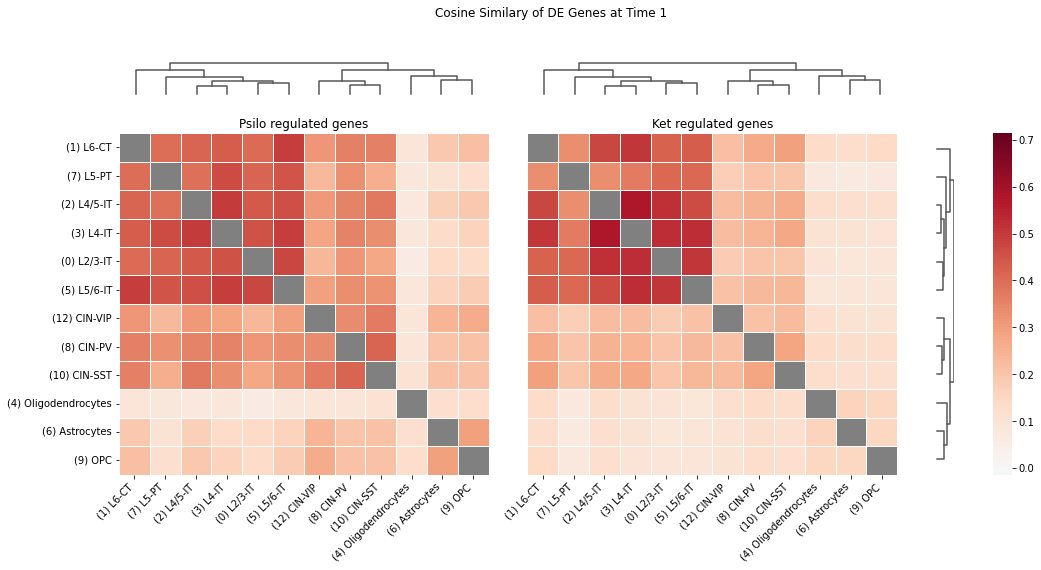

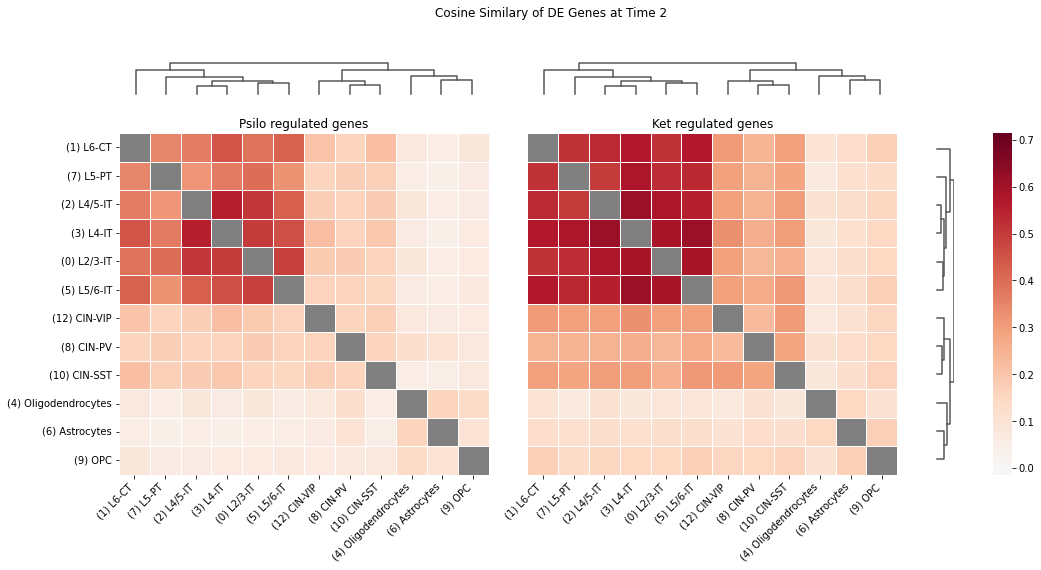

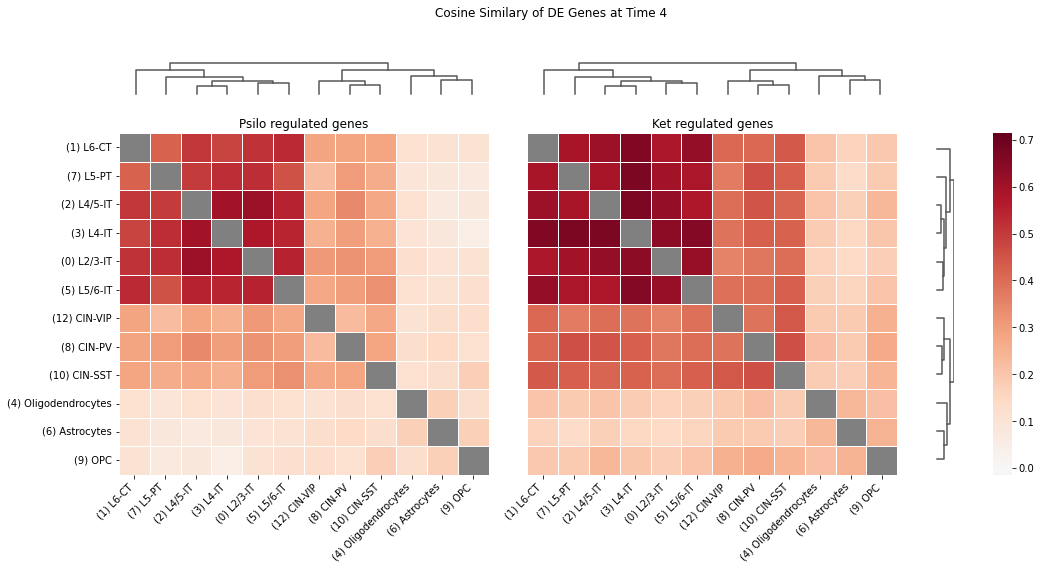

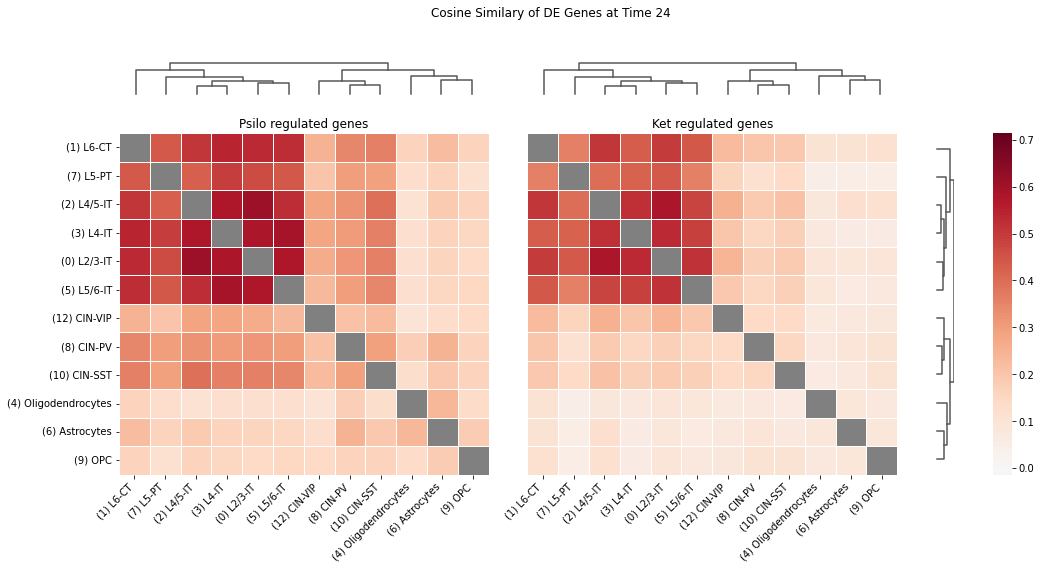

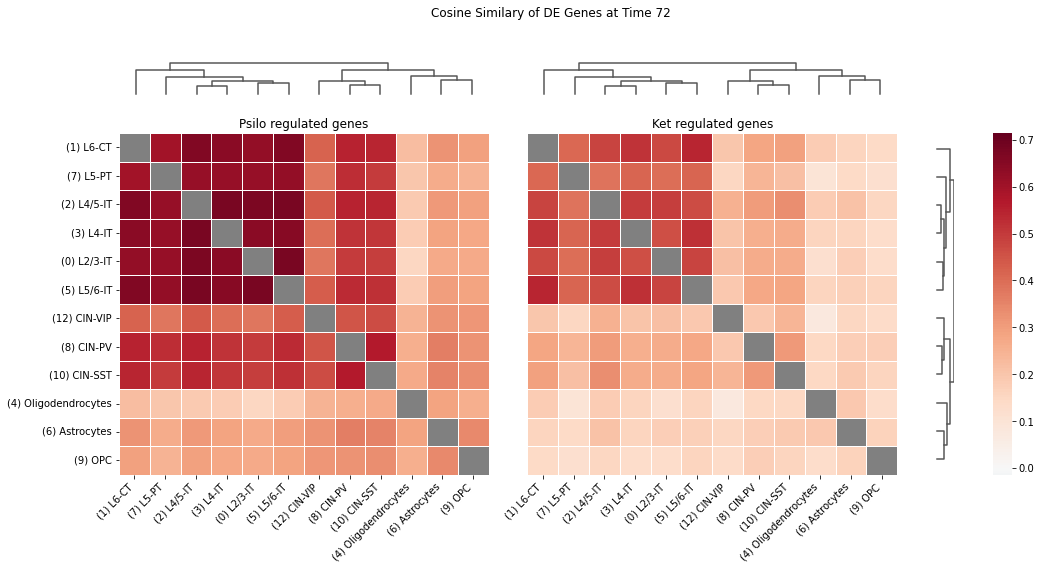

In [41]:
for time in trt_times:
    gs_kw = dict(width_ratios=[2,2,0.1, 0.1], height_ratios=[0.2,2],
                wspace=0.2, hspace=0.2)
    fig, axes = plt.subplots(2, 4, figsize=(16, 7.6), gridspec_kw=gs_kw)
    heatmap_drugs = ['Psilo','Ket']
    heatmap_idx = cluster_lookup['name'].to_list()
    heatmap_cluster_labels = cluster_lookup.apply(lambda row: f"({row['id']}) {row['name']}", axis=1).to_list()

    axes[0][2].remove()
    axes[0][3].remove()
    for ax in [axes[0][0], axes[0][1]]:
        sc.pl.dendrogram(adata, 'leiden', orientation='top', remove_labels=True, show=False, ax=ax)
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(xmin, xmax+0)

    for ax in [axes[1][2]]:
        sc.pl.dendrogram(adata, 'leiden', orientation='right', remove_labels=True, show=False, ax=ax)
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymax, ymin)

    for col in [0,1]:
        sns.heatmap(
            non_directional_overlap_matrix(heatmap_drugs[col], time, cosine_similarity), 
            cmap='RdBu_r', cbar_ax=axes[1][3], #RdBu_r or Spectral_r
            center=0.0, vmin=extend_limits((0.0, 0.7))[0], vmax=extend_limits((0.0, 0.7))[1],
            linewidth=0.5, 
            ax=axes[1][col]
        )
        axes[1][col].set_facecolor('grey')

        axes[1][col].set_title(f"{heatmap_drugs[col]} regulated genes")
        axes[1][col].set_xticks(np.arange(len(heatmap_idx))+0.5, labels=heatmap_cluster_labels, rotation=45, ha='right')
        if col==0:
            axes[1][col].set_yticks(np.arange(len(heatmap_idx))+0.5, labels=heatmap_cluster_labels, rotation=0)
        else:
            axes[1][col].set_yticks([])

    fig.suptitle(f"Cosine Similary of DE Genes at Time {time}")
    fig.savefig(os.path.join(this_figure_dir, f"time_{time}_de_gene_overlap_cosine_nondirectional.png"))
    fig.savefig(os.path.join(this_figure_dir, f"time_{time}_de_gene_overlap_cosine_nondirectional.pdf"))

In [42]:
os.listdir(this_figure_dir)

['time_72_de_gene_overlap_cosine_nondirectional.png',
 'time_2_de_gene_overlap_cosine_nondirectional.pdf',
 'time_1_de_gene_overlap_cosine_nondirectional.pdf',
 'time_1_de_gene_overlap_cosine_nondirectional.png',
 'time_24_de_gene_overlap_cosine_nondirectional.png',
 'time_2_de_gene_overlap_cosine_nondirectional.png',
 'time_72_de_gene_overlap_cosine_nondirectional.pdf',
 'time_24_de_gene_overlap_cosine_nondirectional.pdf',
 'time_4_de_gene_overlap_cosine_nondirectional.pdf',
 'time_4_de_gene_overlap_cosine_nondirectional.png']

# Figure 3 (formerly 4)

4.	Create 10 DEG volcano plots for L5 ET cell cluster –  5 (per timepoint) x 2 (Ket and Psi).  List out the most top 10 names of most upregulated and most downregulated genes beneath the plots

In [43]:
this_figure_dir = f'{settings.fig_path}/figure_3'
os.makedirs(this_figure_dir, exist_ok=True)

In [44]:
memento_full.head(2)

gene  initial_de  initial_de_pval  initial_de_padj drug cluster  time
0  Prrc2b    0.162677     4.414582e-10         0.000005  Ket       0     1
1  Slc4a4   -0.124186     1.556089e-09         0.000010  Ket       0     1

In [45]:
memento_L5_ET = memento_full[memento_full['cluster'] == '7'].copy()
memento_L5_ET['drug'].unique(), memento_L5_ET['cluster'].unique(), memento_L5_ET['time'].unique()

(array(['Ket', 'Psilo'], dtype=object),
 array(['7'], dtype=object),
 array([ 1,  2,  4, 24, 72]))

In [46]:
df = memento_L5_ET[(memento_L5_ET['drug'] == 'Ket') &
                  (memento_L5_ET['time'] == 1)]

In [47]:
df.head()

gene  initial_de  initial_de_pval  initial_de_padj drug cluster  time
0    Kazn    0.395823         0.000028         0.007828  Ket       7     1
1     Alk    0.561107         0.000017         0.007828  Ket       7     1
2    Btg2   -0.764737         0.000008         0.007828  Ket       7     1
3  Camk1g    0.303381         0.000036         0.007828  Ket       7     1
4   Grb14    0.350195         0.000029         0.007828  Ket       7     1

In [48]:
def make_volcano(
    df,
    ax,
    outfile=None,
    title=None,
    xmax=2,
    ymax=10,
    FDR_threshold=0.05,
):
    df = df.copy()
    df['negLogP'] = -np.log10(df['initial_de_pval'])
    df['negLogP'] = np.clip(df['negLogP'], 0, ymax)
    df['logFC'] = np.clip(df['initial_de'], -xmax, xmax)
    df['FDR'] = df['initial_de_padj']
    df['color'] = df.apply(
        lambda row: 'lightgrey' if row['FDR'] > FDR_threshold else ('tomato' if row['logFC'] > 0 else 'steelblue'),
        axis = 1,
    )
    
    plt.style.use('default')
    ax.grid(False)
    ax.scatter(data = df, x='logFC', y='negLogP', c='color', 
               s=5)
    
    labels = []
    for _,row in df.sort_values('negLogP', ascending=False).head(10).iterrows():
        labels.append(ax.text(row['logFC'], row['negLogP'], s=row['gene']))
    adjust_text(labels, force_text=(0.2,0.6), arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
    
    ax.set(title = title,
          xlabel='log2 FC',
          ylabel='-log10 P-Value',
          xlim=extend_limits((-xmax,xmax)),
           ylim=extend_limits((0, ymax)),
          )
    sns.despine(ax=ax)
    
    return ax

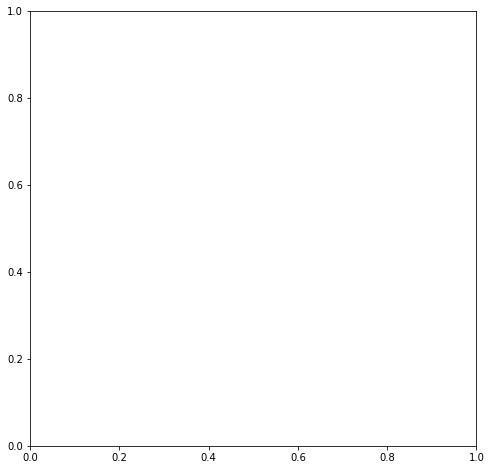

In [49]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
# make_volcano(df, ax, title=f"L5-ET Differential Expression (Ketamine, 1 hours)")

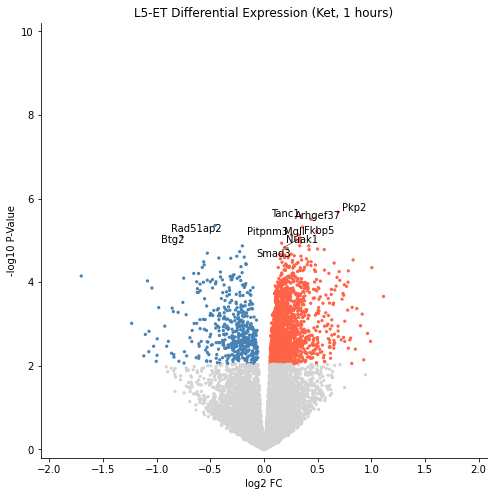

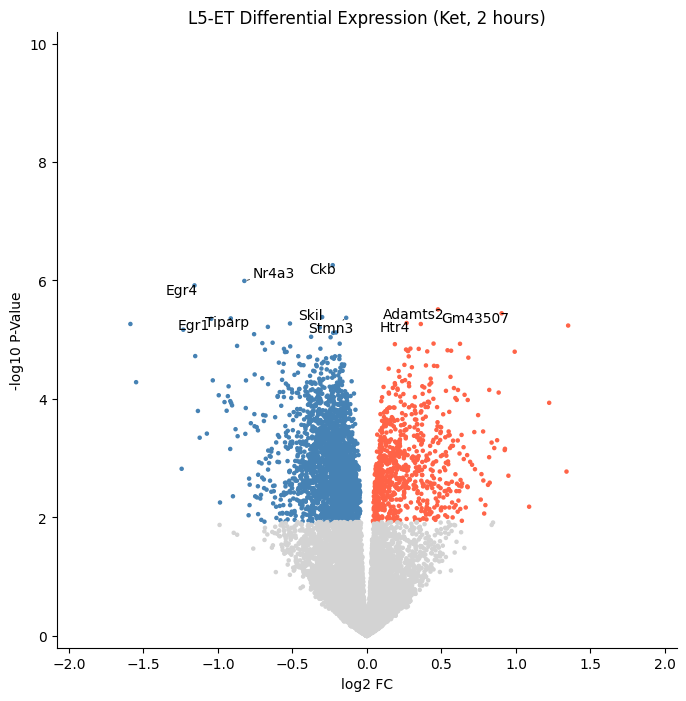

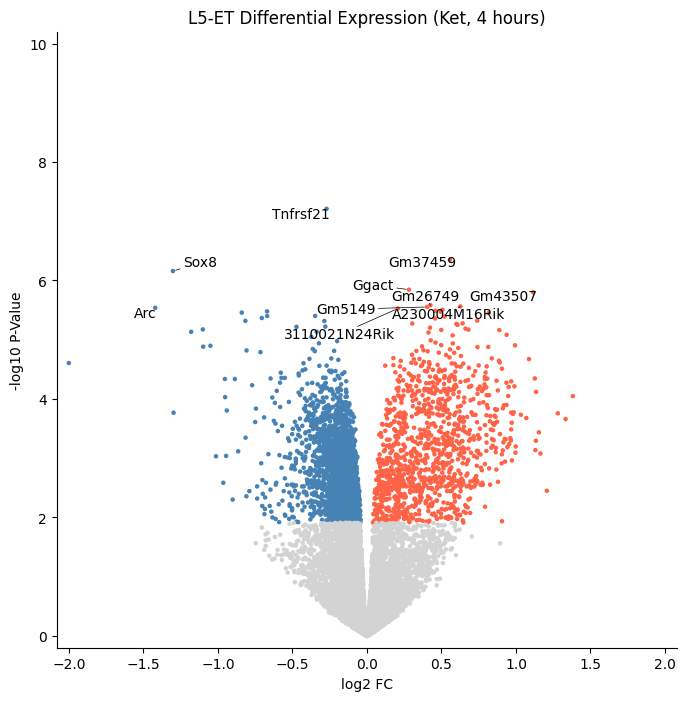

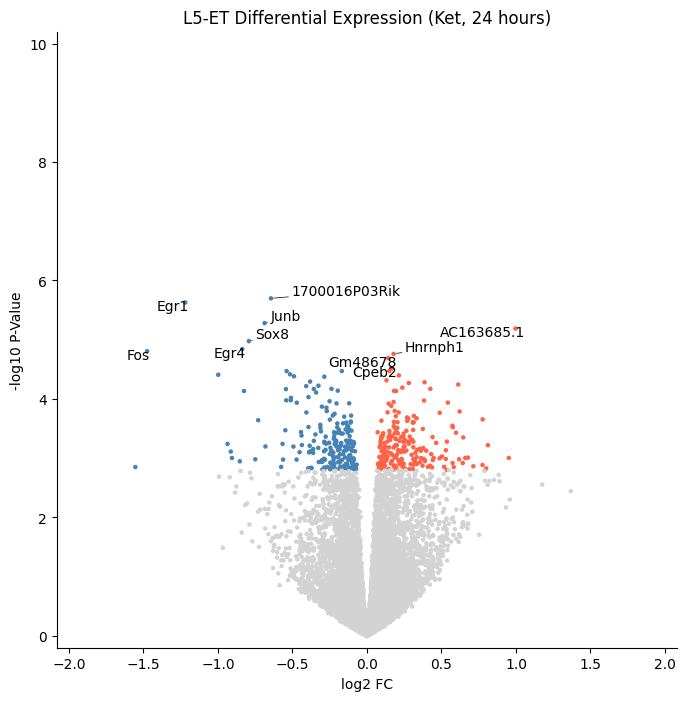

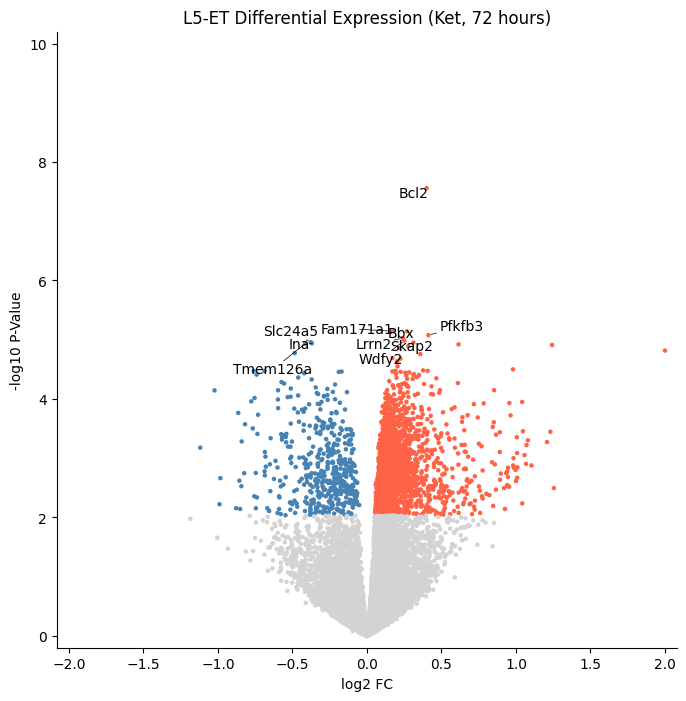

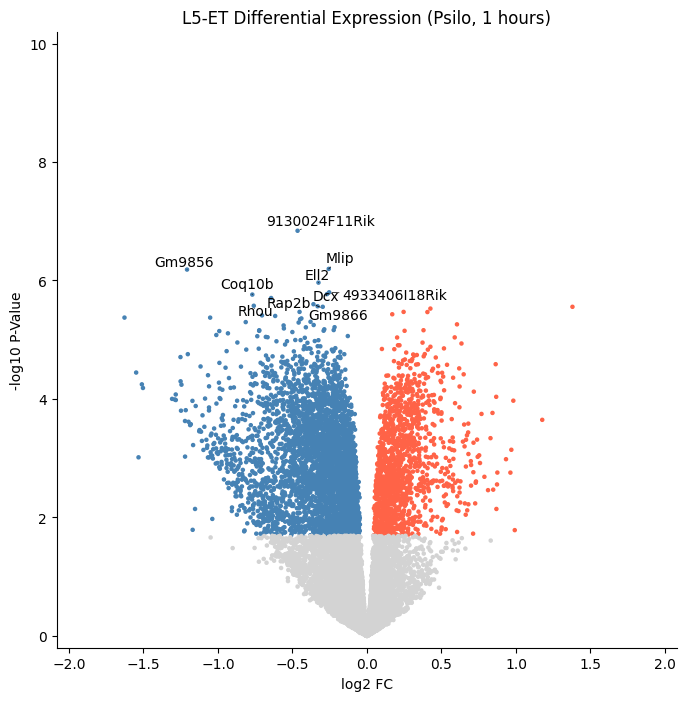

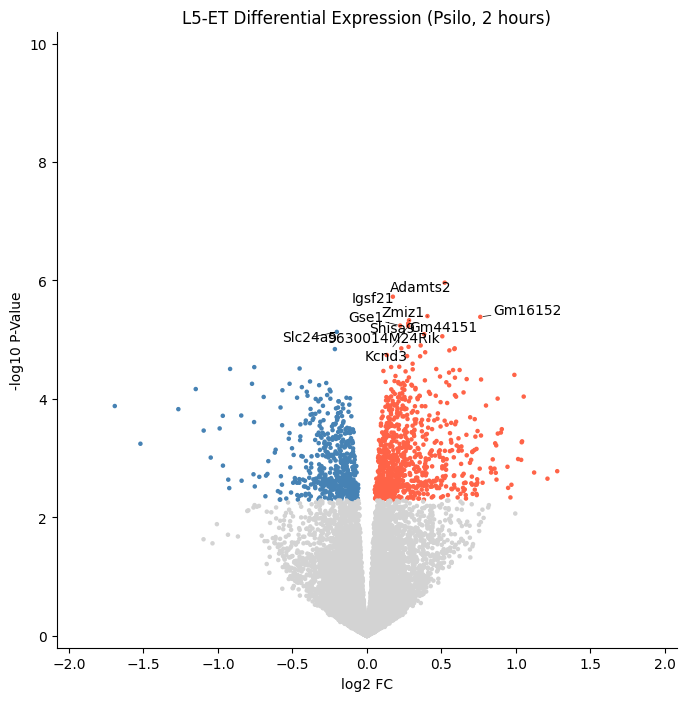

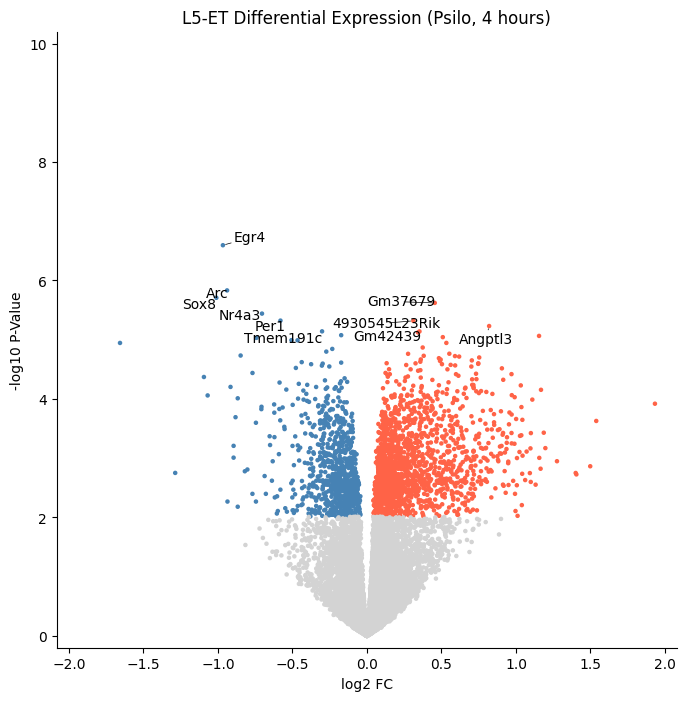

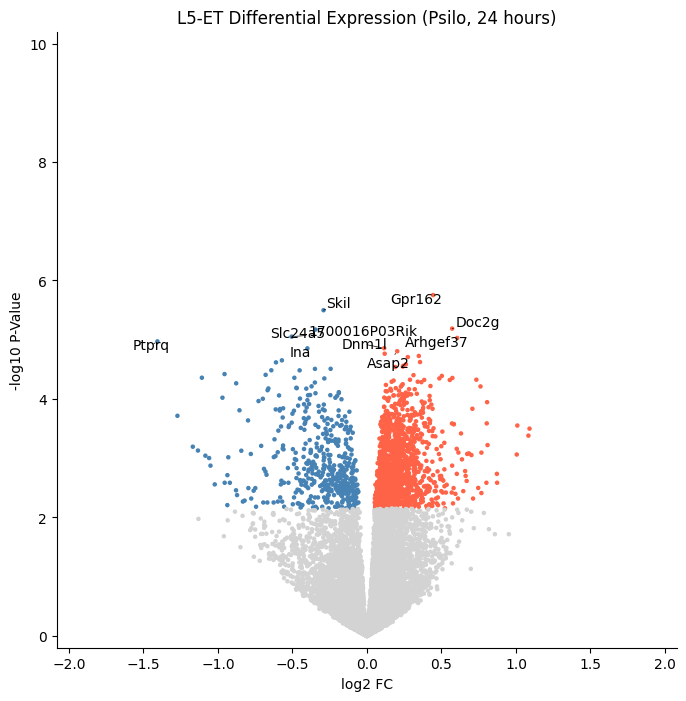

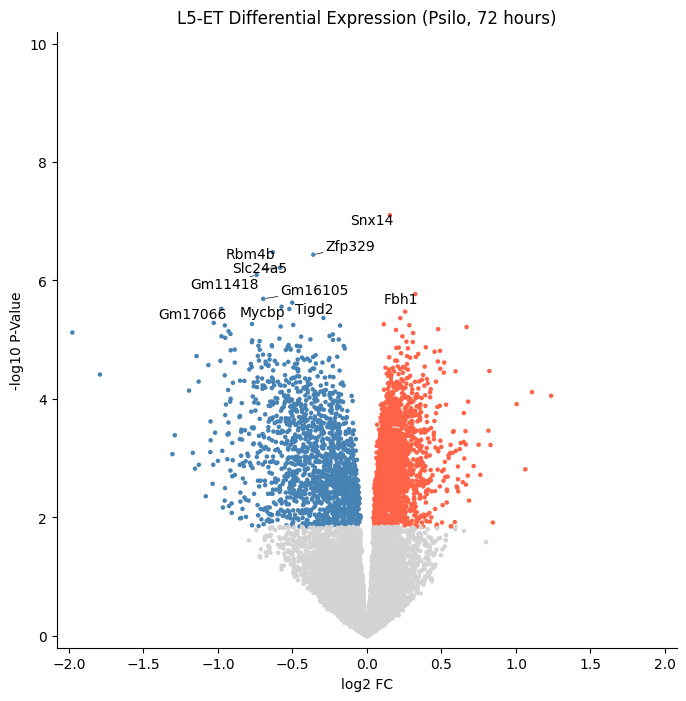

In [50]:
for (drug, time), group in memento_L5_ET.groupby(['drug','time']):
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    make_volcano(group, ax, title=f"L5-ET Differential Expression ({drug}, {time} hours)")
    fig.savefig(f"{this_figure_dir}/L5_ET_volcano_{drug}_{time}.png")
    fig.savefig(f"{this_figure_dir}/L5_ET_volcano_{drug}_{time}.pdf")

In [51]:
sorted(os.listdir(this_figure_dir))

['L5_ET_volcano_Ket_1.pdf',
 'L5_ET_volcano_Ket_1.png',
 'L5_ET_volcano_Ket_2.pdf',
 'L5_ET_volcano_Ket_2.png',
 'L5_ET_volcano_Ket_24.pdf',
 'L5_ET_volcano_Ket_24.png',
 'L5_ET_volcano_Ket_4.pdf',
 'L5_ET_volcano_Ket_4.png',
 'L5_ET_volcano_Ket_72.pdf',
 'L5_ET_volcano_Ket_72.png',
 'L5_ET_volcano_Psilo_1.pdf',
 'L5_ET_volcano_Psilo_1.png',
 'L5_ET_volcano_Psilo_2.pdf',
 'L5_ET_volcano_Psilo_2.png',
 'L5_ET_volcano_Psilo_24.pdf',
 'L5_ET_volcano_Psilo_24.png',
 'L5_ET_volcano_Psilo_4.pdf',
 'L5_ET_volcano_Psilo_4.png',
 'L5_ET_volcano_Psilo_72.pdf',
 'L5_ET_volcano_Psilo_72.png',
 'pseudobulk_clusters_counts']

## Try again with edgeR because memento sucks

In [52]:
cluster_lookup

id              name    color
1    1             L6-CT  #A9CFA4
7    7             L5-PT  #F4C700
2    2           L4/5-IT  #8650F5
3    3             L4-IT  #8650F5
0    0           L2/3-IT  #8650F5
5    5           L5/6-IT  #8650F5
11  12           CIN-VIP  #648FFF
8    8            CIN-PV  #B00B00
10  10           CIN-SST  #FE6100
4    4  Oligodendrocytes  #A3B5CC
6    6        Astrocytes  #D8A4C7
9    9               OPC  #A8DADC

In [15]:
samples = pd.read_csv("../../../PsiloKet snRNA Seq (2022-11-19).csv").astype({"Mouse ID": str})
# Select samples with NO reason for exclusion
samples = samples[samples["Reason for Exclusion"].isna()]
# Swapped sex
samples.loc[np.isin(samples['Mouse ID'], ["470"]), 'Sex'] = 'M'
samples.loc[np.isin(samples['Mouse ID'], ["344"]), 'Seq ID'] = '6141-CL-3'
samples.loc[np.isin(samples['Mouse ID'], ["338"]), 'Seq ID'] = '6141-CL-4'
dropped_samples = [
    "39",
    "40",
    "41",
    "42",
    "299",
    "301"
]
samples = samples[~np.in1d(samples["Mouse ID"], dropped_samples)]

samples["label"] = samples["Timepoint"] + "_" + samples["Drug"] + "_" + samples["Sex"] + "_" + samples["Mouse ID"]
sample_metadata = samples[['Drug','Timepoint','Seq ID', 'label']].copy()

In [54]:
os.makedirs(os.path.join(this_figure_dir, 'pseudobulk_clusters_counts'), exist_ok=True)

In [57]:
L5_ET_pseudobulk_metadata = sample_metadata.copy()
L5_ET_pseudobulk_metadata['filepath'] = L5_ET_pseudobulk_metadata.apply(
    lambda row: os.path.join(this_figure_dir, 'pseudobulk_clusters_counts', 'cluster_{cluster}_{label}.tsv').format(
        cluster = 'L5_PT',
        label = row['label'],
    ),
    axis=1
)
L5_ET_pseudobulk_metadata.to_csv(os.path.join(this_figure_dir, 'pseudobulk_clusters_counts', 'pseudobulk_metadata.csv'), index=False)
L5_ET_pseudobulk_metadata.head()

Drug Timepoint     Seq ID          label  \
0  none        0h  6155-CL-1  0h_none_F_346   
1  none        0h  6128-CL-1  0h_none_F_347   
2  none        0h  6881-CL-1  0h_none_F_465   
3  none        0h  6881-CL-2  0h_none_F_467   
5  none        0h  5889-CL-1  0h_none_M_291   

                                            filepath  
0  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
1  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
2  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
3  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
5  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...

In [58]:
for index, row in L5_ET_pseudobulk_metadata.iterrows():
    cluster_name = 'L5-PT'
    label = row['label']
    drug = row['Drug']
    filepath = row['filepath']
    
    cdata = rna_data[(rna_data.obs['leiden'] == '7') &
                    (rna_data.obs['label'] == label)].copy()
    pseudobulk_matrix = cdata.X.todense().astype(int).sum(axis=0)
    pseudobulk = np.squeeze(np.asarray(pseudobulk_matrix))
    counts_tsv = pd.Series(pseudobulk, index=cdata.var.index)
    counts_tsv.to_csv(filepath, sep='\t')

In [59]:
this_figure_dir

'/nfs/turbo/umms-kykwan/projects/alex_kwan/paper_figures/figures/top12_no11/figure_3'

# Figure 4 (formerly 5)

5.	Create 10 DEG volcano plots for IT cell cluster (combining L2/3, L4, L4/5, L6 IT) –  5 (per timepoint) x 2 (Ket and Psi).  List out the most top 10 names of most upregulated and most downregulated genes beneath the plots

In [62]:
this_figure_dir = f'{settings.fig_path}/figure_4'
os.makedirs(this_figure_dir, exist_ok=True)

## Sequencing Saturation

In [63]:
sample_ids = samples[["label", "Seq ID"]]
sample_ids.head()

label     Seq ID
0  0h_none_F_346  6155-CL-1
1  0h_none_F_347  6128-CL-1
2  0h_none_F_465  6881-CL-1
3  0h_none_F_467  6881-CL-2
5  0h_none_M_291  5889-CL-1

In [64]:
# Read sequencing saturation
metrics = pd.read_csv("../../../10x_metrics.csv").set_index("Sample")
# Convert 40.5% to 0.405
metrics["Sequencing Saturation"] = metrics["Sequencing Saturation"].str.rstrip('%').astype('float') / 100.0
# Using only the columns we care about
metrics = metrics[["Sequencing Saturation"]]
metrics.head()

Sequencing Saturation
Sample                          
6155-CL-1                  0.405
6128-CL-1                  0.634
6881-CL-1                  0.527
6881-CL-2                  0.497
5905-CL-1                  0.853

In [65]:
# Add Seq ID to adata.obs
adata.obs = (adata.obs.reset_index() # Reset index into a column so that it is not lost
             .merge(sample_ids, how='left', on="label") # Add Seq ID
             .merge(metrics, how='left', left_on="Seq ID", right_index=True) # Add Sequencing Saturation
             .set_index("index")) # Re-add index

# 0.25 as specified by memento docs for 10x v3
adata.obs['capture_rate'] = 0.25 * adata.obs['Sequencing Saturation']
adata.obs

time time_str  drug sex  \
index                                                       
AAACCCAAGTAGACAT-1-0h_none_F_346     0        0  none   F   
AAACCCAAGTATCCTG-1-0h_none_F_346     0        0  none   F   
AAACCCACAATTAGGA-1-0h_none_F_346     0        0  none   F   
AAACCCACAGTCGGAA-1-0h_none_F_346     0        0  none   F   
AAACCCAGTCATATGC-1-0h_none_F_346     0        0  none   F   
...                                ...      ...   ...  ..   
TTTGTTGGTATGTGTC-1-72h_Ket_M_334    72       72   Ket   M   
TTTGTTGGTCGGCACT-1-72h_Ket_M_334    72       72   Ket   M   
TTTGTTGTCCTAAACG-1-72h_Ket_M_334    72       72   Ket   M   
TTTGTTGTCGACGCGT-1-72h_Ket_M_334    72       72   Ket   M   
TTTGTTGTCGGAGTAG-1-72h_Ket_M_334    72       72   Ket   M   

                                 approx_reads_per_cell     date  \
index                                                             
AAACCCAAGTAGACAT-1-0h_none_F_346                   25K   4/5/22   
AAACCCAAGTATCCTG-1-0h_none_F_346                   25K   4/5/22   
AAACCCACAATTAGGA-1-0h_none_F_346                   25K   4/5/22   
AAACCCACAGTCGGAA-1-0h_none_F_346                   25K   4/5/22   
AAACCCAGTCATATGC-1-0h_none_F_346                   25K   4/5/22   
...                                                ...      ...   
TTTGTTGGTATGTGTC-1-72h_Ket_M_334                   25K  4/19/22   
TTTGTTGGTCGGCACT-1-72h_Ket_M_334                   25K  4/19/22   
TTTGTTGTCCTAAACG-1-72h_Ket_M_334                   25K  4/19/22   
TTTGTTGTCGACGCGT-1-72h_Ket_M_334                   25K  4/19/22   
TTTGTTGTCGGAGTAG-1-72h_Ket_M_334                   25K  4/19/22   

                                          label batch sample  \
index                                                          
AAACCCAAGTAGACAT-1-0h_none_F_346  0h_none_F_346  6155      0   
AAACCCAAGTATCCTG-1-0h_none_F_346  0h_none_F_346  6155      0   
AAACCCACAATTAGGA-1-0h_none_F_346  0h_none_F_346  6155      0   
AAACCCACAGTCGGAA-1-0h_none_F_346  0h_none_F_346  6155      0   
AAACCCAGTCATATGC-1-0h_none_F_346  0h_none_F_346  6155      0   
...                                         ...   ...    ...   
TTTGTTGGTATGTGTC-1-72h_Ket_M_334  72h_Ket_M_334  6163     41   
TTTGTTGGTCGGCACT-1-72h_Ket_M_334  72h_Ket_M_334  6163     41   
TTTGTTGTCCTAAACG-1-72h_Ket_M_334  72h_Ket_M_334  6163     41   
TTTGTTGTCGACGCGT-1-72h_Ket_M_334  72h_Ket_M_334  6163     41   
TTTGTTGTCGGAGTAG-1-72h_Ket_M_334  72h_Ket_M_334  6163     41   

                                  n_genes_by_counts  log1p_n_genes_by_counts  \
index                                                                          
AAACCCAAGTAGACAT-1-0h_none_F_346               3991                 8.292048   
AAACCCAAGTATCCTG-1-0h_none_F_346               3357                 8.119101   
AAACCCACAATTAGGA-1-0h_none_F_346               4313                 8.369621   
AAACCCACAGTCGGAA-1-0h_none_F_346                613                 6.419995   
AAACCCAGTCATATGC-1-0h_none_F_346               4361                 8.380686   
...                                             ...                      ...   
TTTGTTGGTATGTGTC-1-72h_Ket_M_334               3421                 8.137980   
TTTGTTGGTCGGCACT-1-72h_Ket_M_334                887                 6.788972   
TTTGTTGTCCTAAACG-1-72h_Ket_M_334               1111                 7.013915   
TTTGTTGTCGACGCGT-1-72h_Ket_M_334               4010                 8.296796   
TTTGTTGTCGGAGTAG-1-72h_Ket_M_334               3034                 8.017967   

                                  total_counts  log1p_total_counts  n_counts  \
index                                                                          
AAACCCAAGTAGACAT-1-0h_none_F_346       17264.0            9.756436   17264.0   
AAACCCAAGTATCCTG-1-0h_none_F_346        8862.0            9.089641    8862.0   
AAACCCACAATTAGGA-1-0h_none_F_346       18289.0            9.814110   18289.0   
AAACCCACAGTCGGAA-1-0h_none_F_346        1387.0            7.235619    1387.0   
AAACCCAGTCATAT

## Run Memento for Lump

In [66]:
cluster_lookup

id              name    color
1    1             L6-CT  #A9CFA4
7    7             L5-PT  #F4C700
2    2           L4/5-IT  #8650F5
3    3             L4-IT  #8650F5
0    0           L2/3-IT  #8650F5
5    5           L5/6-IT  #8650F5
11  12           CIN-VIP  #648FFF
8    8            CIN-PV  #B00B00
10  10           CIN-SST  #FE6100
4    4  Oligodendrocytes  #A3B5CC
6    6        Astrocytes  #D8A4C7
9    9               OPC  #A8DADC

In [67]:
results = {}

In [68]:
it_adata = adata[adata.obs['leiden'].isin(['0','3','2','5'])].copy()

In [69]:
# for time, drug in itertools.product(trt_times, trt_drugs):
# # def write_IT_memento_results(time_drug_tup):
# #     time, drug = time_drug_tup
#     categorical_covariates = ["sex"]
#     group = f"{time}h_{drug}"
#     print(f"{group} vs ctrl")
    
#     data = it_adata[(np.isin(it_adata.obs["drug"], [drug, "none"])) &
#             (np.isin(it_adata.obs["time_str"], [time, "0"]))].copy()
#     data.obs["stim"] = data.obs["drug"].replace({drug: 1, "none": 0})
    
#     if data.shape[0] < 100:
#         print(f"Skipping {group}, < 100 cells")
#         continue

#     # Make the columns into numbers
#     for col in categorical_covariates:
#         data.obs[col] = pd.factorize(data.obs[col])[0].astype(float)  
        
#     cols = ["stim"] + categorical_covariates
#     print("Data Shape:", data.shape)
#     memento.setup_memento(data, q_column='capture_rate')
#     memento.create_groups(data, label_columns=cols)
    
#     if (data.obs.groupby(cols).size() < 10).any():
#         print(f"Skipping {group}, < 10 cells in some groups")
#         continue
        
#     memento.compute_1d_moments(data)
#     print("Data Shape after compute_1d_moments:", data.shape)
    
#     sample_meta = memento.get_groups(data)
#     treatment_df = sample_meta[['stim']]
#     covariates_df = sample_meta.drop('stim', axis=1)
    
#     memento.ht_1d_moments(data, 
#                           treatment=treatment_df,
#                           covariate=covariates_df,
#                           num_boot=5000, 
#                           verbose=1,
#                           num_cpus=36)
    
#     result_1d = memento.get_1d_ht_result(data)
    
#     # Correct p-vals
#     _, result_1d["de_pval_adj"], _, _ = multipletests(
#     result_1d["de_pval"], alpha=0.05, method='fdr_bh'
#     )

#     _, result_1d["dv_pval_adj"], _, _ = multipletests(
#         result_1d["dv_pval"], alpha=0.05, method='fdr_bh'
#     )
    
#     results = result_1d.sort_values(by=["de_pval_adj", "dv_pval_adj"])
#     xlsx_filename = f"{this_figure_dir}/memento_DE_{drug}_{time}h.xlsx"
#     with pd.ExcelWriter(xlsx_filename, engine="xlsxwriter") as writer:
#         results.to_excel(writer)
# #     return xlsx_filename

## Re-read memento lump results (for fast reproducibility)

In [70]:
def process_IT_combination(drug, time):
    combination_memento = pd.read_excel(
        os.path.join(this_figure_dir, f"memento_DE_{drug}_{time}h.xlsx"),
    )
    combination_memento = combination_memento[['gene', 'de_coef', 'de_pval', 'de_pval_adj']]
    combination_memento = combination_memento.rename(columns={
        'de_coef':'initial_de',
        'de_pval': 'initial_de_pval',
        'de_pval_adj':'initial_de_padj'
    })
    
    combination_memento['drug'] = drug
    combination_memento['time'] = time
    return combination_memento

In [71]:
from tqdm.contrib.itertools import product as progressbar_product
combination_mementos = [
    process_IT_combination(drug,time) 
    for drug,time
    in progressbar_product(trt_drugs,trt_times)
]
memento_IT = pd.concat(combination_mementos)
print(memento_IT.shape)
memento_IT.head()

  0%|          | 0/10 [00:00<?, ?it/s]

(126472, 6)


gene  initial_de  initial_de_pval  initial_de_padj drug  time
0  Lpgat1    0.123609     1.527522e-10         0.000002  Ket     1
1     Mkx   -0.108052     2.079828e-09         0.000013  Ket     1
2  Lrrc49    0.152214     5.000465e-09         0.000016  Ket     1
3    Tesc    0.220526     4.714644e-09         0.000016  Ket     1
4  Mapk11    0.208848     9.215292e-09         0.000023  Ket     1

In [72]:
for (drug, time), df in memento_IT.groupby(['drug','time']):
    print(drug, time)

Ket 1
Ket 2
Ket 4
Ket 24
Ket 72
Psilo 1
Psilo 2
Psilo 4
Psilo 24
Psilo 72


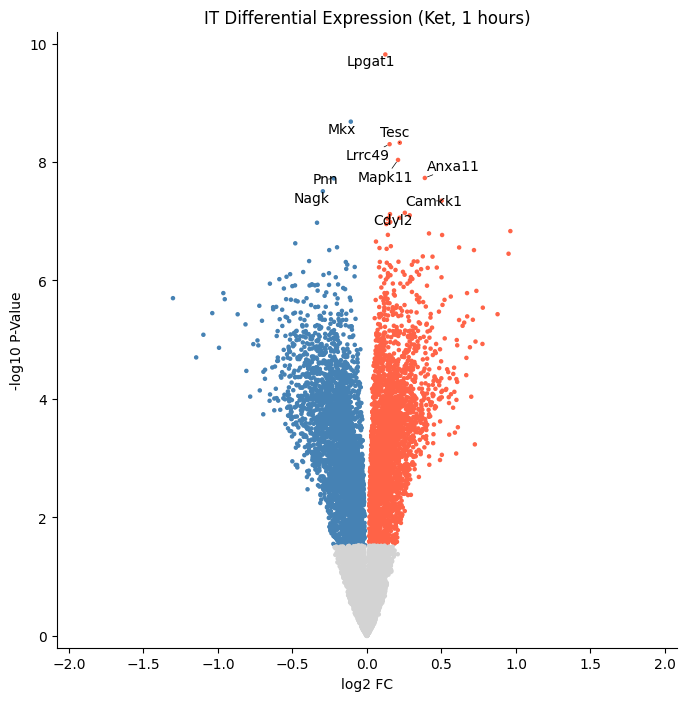

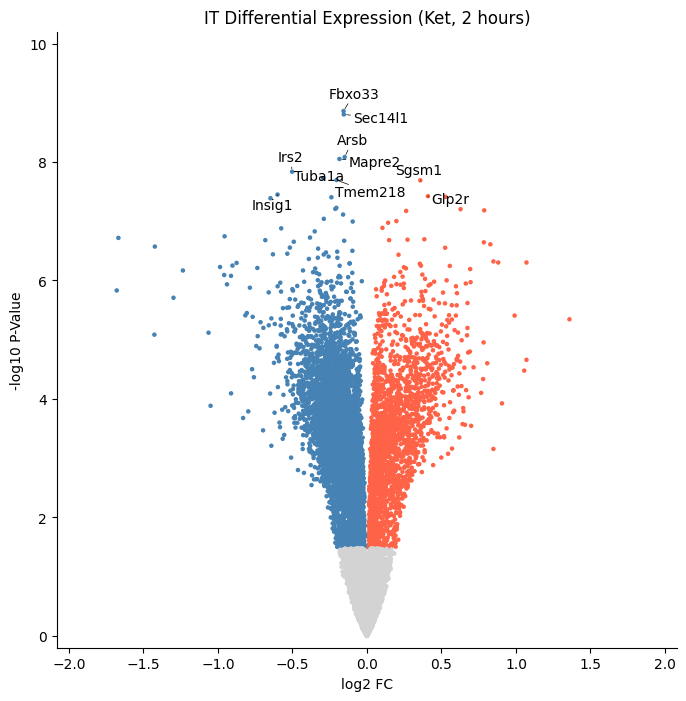

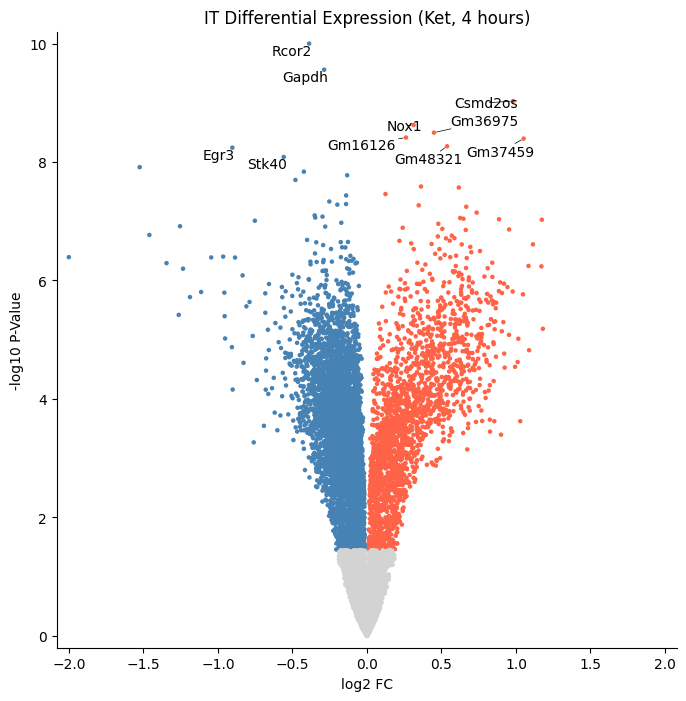

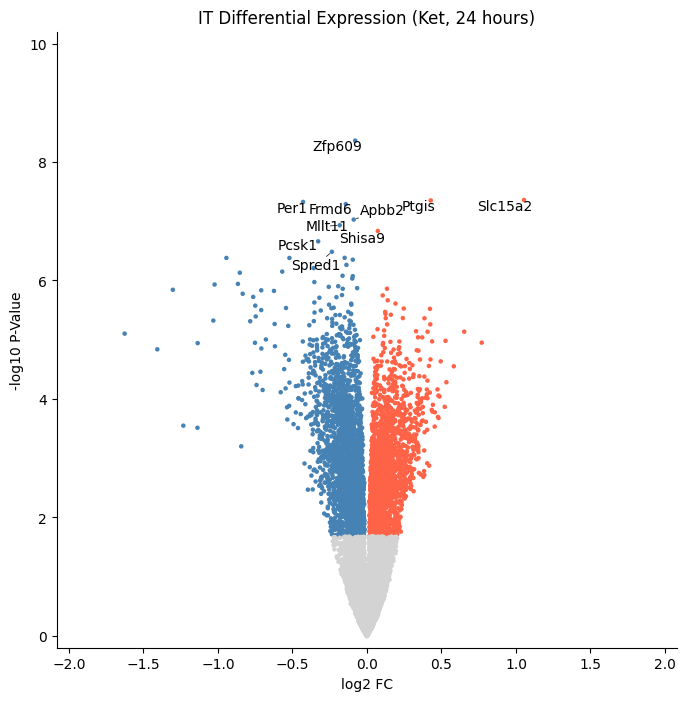

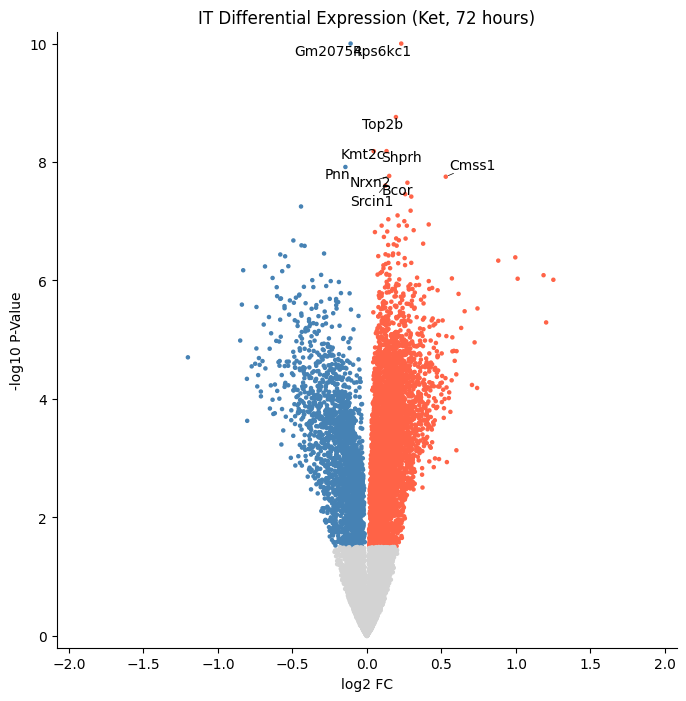

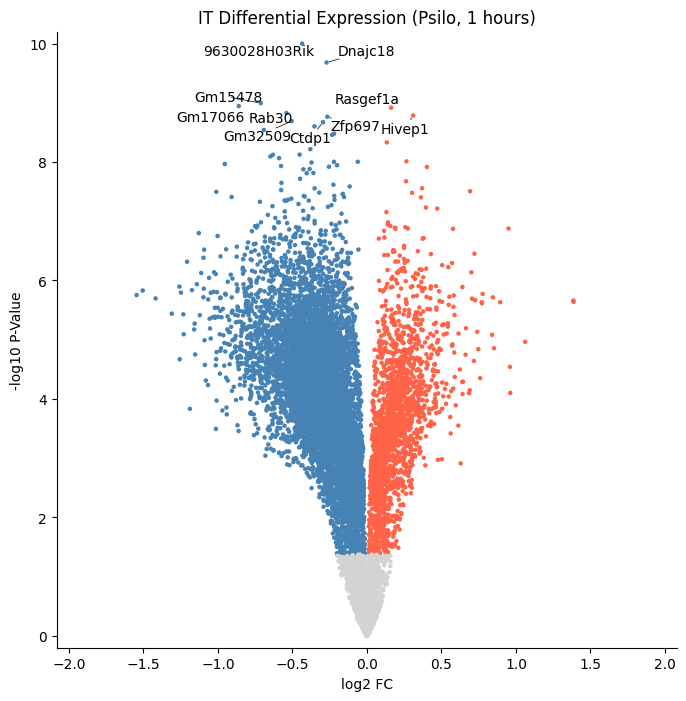

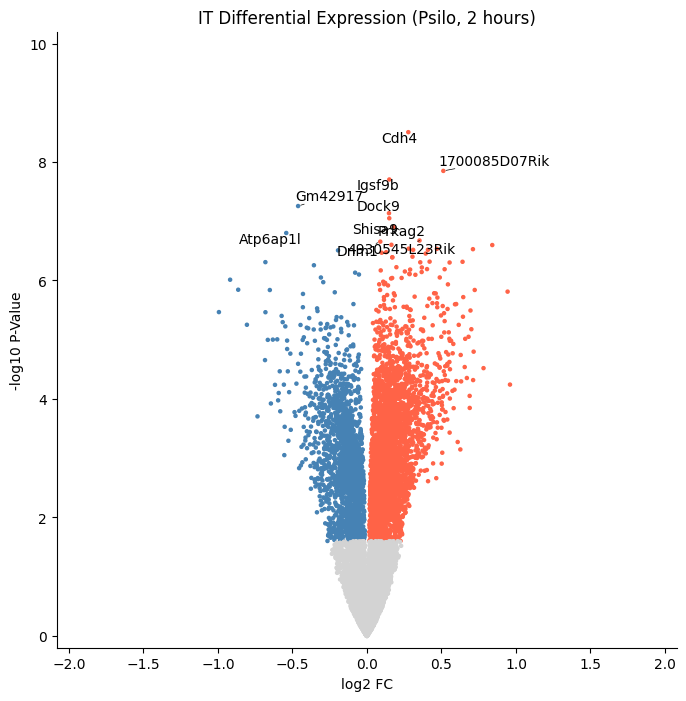

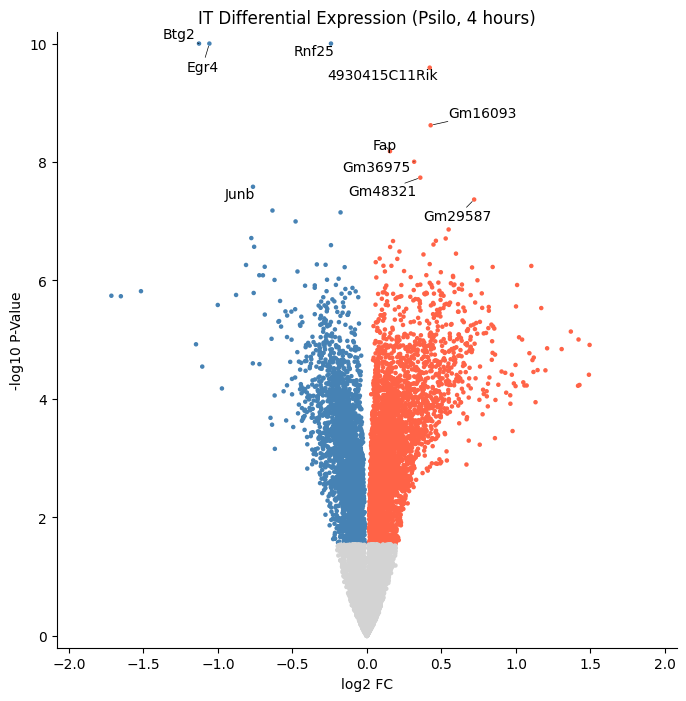

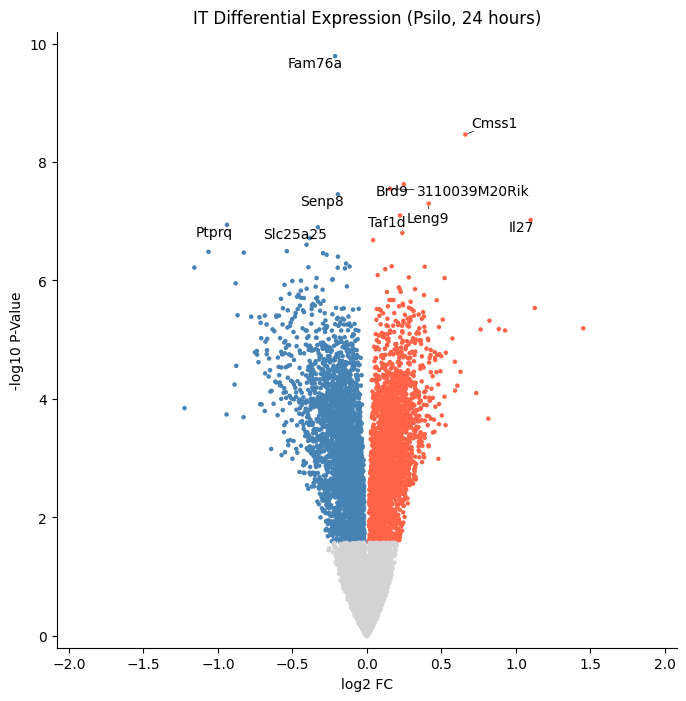

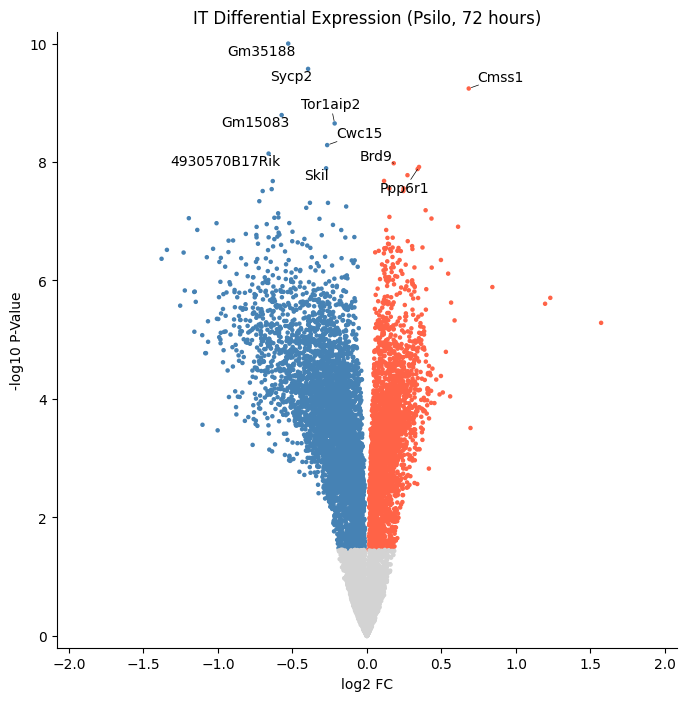

In [73]:
for (drug, time), group in memento_IT.groupby(['drug','time']):
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    make_volcano(group, ax, title=f"IT Differential Expression ({drug}, {time} hours)", ymax=10)
    fig.savefig(f"{this_figure_dir}/IT_volcano_{drug}_{time}.png")
    fig.savefig(f"{this_figure_dir}/IT_volcano_{drug}_{time}.pdf")

In [74]:
sorted(os.listdir(this_figure_dir))

['IT_volcano_Ket_1.pdf',
 'IT_volcano_Ket_1.png',
 'IT_volcano_Ket_2.pdf',
 'IT_volcano_Ket_2.png',
 'IT_volcano_Ket_24.pdf',
 'IT_volcano_Ket_24.png',
 'IT_volcano_Ket_4.pdf',
 'IT_volcano_Ket_4.png',
 'IT_volcano_Ket_72.pdf',
 'IT_volcano_Ket_72.png',
 'IT_volcano_Psilo_1.pdf',
 'IT_volcano_Psilo_1.png',
 'IT_volcano_Psilo_2.pdf',
 'IT_volcano_Psilo_2.png',
 'IT_volcano_Psilo_24.pdf',
 'IT_volcano_Psilo_24.png',
 'IT_volcano_Psilo_4.pdf',
 'IT_volcano_Psilo_4.png',
 'IT_volcano_Psilo_72.pdf',
 'IT_volcano_Psilo_72.png',
 'memento_DE_Ket_1h.xlsx',
 'memento_DE_Ket_24h.xlsx',
 'memento_DE_Ket_2h.xlsx',
 'memento_DE_Ket_4h.xlsx',
 'memento_DE_Ket_72h.xlsx',
 'memento_DE_Psilo_1h.xlsx',
 'memento_DE_Psilo_24h.xlsx',
 'memento_DE_Psilo_2h.xlsx',
 'memento_DE_Psilo_4h.xlsx',
 'memento_DE_Psilo_72h.xlsx',
 'pseudobulk_clusters_counts']

## Try again with edger

In [75]:
os.makedirs(os.path.join(this_figure_dir, 'pseudobulk_clusters_counts'), exist_ok=True)

In [76]:
sample_metadata.head()

Drug Timepoint     Seq ID          label
0  none        0h  6155-CL-1  0h_none_F_346
1  none        0h  6128-CL-1  0h_none_F_347
2  none        0h  6881-CL-1  0h_none_F_465
3  none        0h  6881-CL-2  0h_none_F_467
5  none        0h  5889-CL-1  0h_none_M_291

In [77]:
IT_pseudobulk_metadata = sample_metadata.copy()
IT_pseudobulk_metadata['filepath'] = IT_pseudobulk_metadata.apply(
    lambda row: os.path.join(this_figure_dir, 'pseudobulk_clusters_counts', 'cluster_{cluster}_{label}.tsv').format(
        cluster = 'IT',
        label = row['label'],
    ),
    axis=1
)
IT_pseudobulk_metadata.to_csv(os.path.join(this_figure_dir, 'pseudobulk_clusters_counts', 'pseudobulk_metadata.csv'), index=False)
IT_pseudobulk_metadata.head()

Drug Timepoint     Seq ID          label  \
0  none        0h  6155-CL-1  0h_none_F_346   
1  none        0h  6128-CL-1  0h_none_F_347   
2  none        0h  6881-CL-1  0h_none_F_465   
3  none        0h  6881-CL-2  0h_none_F_467   
5  none        0h  5889-CL-1  0h_none_M_291   

                                            filepath  
0  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
1  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
2  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
3  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
5  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...

In [78]:
for index, row in IT_pseudobulk_metadata.iterrows():
    cluster_name = 'IT'
    label = row['label']
    drug = row['Drug']
    filepath = row['filepath']
    
    cdata = rna_data[(rna_data.obs['leiden'].isin(['0','3','2','5'])) &
                    (rna_data.obs['label'] == label)].copy()
    pseudobulk_matrix = cdata.X.todense().astype(int).sum(axis=0)
    pseudobulk = np.squeeze(np.asarray(pseudobulk_matrix))
    counts_tsv = pd.Series(pseudobulk, index=cdata.var.index)
    counts_tsv.to_csv(filepath, sep='\t')

In [79]:
len(sorted(os.listdir(os.path.join(this_figure_dir, 'pseudobulk_clusters_counts'))))

73

# Figure 4 extended - ALL EXCITATORY

combine PT and IT neurons for analysis

In [34]:
this_figure_dir = f'{settings.fig_path}/figure_4_all_excit_pseudobulk_clusters_counts'
os.makedirs(this_figure_dir, exist_ok=True)

In [37]:
sample_metadata.head(2)

Drug Timepoint     Seq ID          label
0  none        0h  6155-CL-1  0h_none_F_346
1  none        0h  6128-CL-1  0h_none_F_347

In [38]:
excitatory_pseudobulk_metadata = sample_metadata.copy()
excitatory_pseudobulk_metadata['filepath'] = excitatory_pseudobulk_metadata.apply(
    lambda row: os.path.join(this_figure_dir, 'cluster_{cluster}_{label}.tsv').format(
        cluster = 'excitatory',
        label = row['label'],
    ),
    axis=1
)
excitatory_pseudobulk_metadata.to_csv(os.path.join(this_figure_dir, 'pseudobulk_metadata.csv'), index=False)
excitatory_pseudobulk_metadata.head()

Drug Timepoint     Seq ID          label  \
0  none        0h  6155-CL-1  0h_none_F_346   
1  none        0h  6128-CL-1  0h_none_F_347   
2  none        0h  6881-CL-1  0h_none_F_465   
3  none        0h  6881-CL-2  0h_none_F_467   
5  none        0h  5889-CL-1  0h_none_M_291   

                                            filepath  
0  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
1  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
2  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
3  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
5  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...

In [39]:
for index, row in excitatory_pseudobulk_metadata.iterrows():
    cluster_name = 'excitatory'
    label = row['label']
    drug = row['Drug']
    filepath = row['filepath']
    
    cdata = rna_data[(rna_data.obs['leiden'].isin(['0','3','2','5','7'])) &
                    (rna_data.obs['label'] == label)].copy()
    pseudobulk_matrix = cdata.X.todense().astype(int).sum(axis=0)
    pseudobulk = np.squeeze(np.asarray(pseudobulk_matrix))
    counts_tsv = pd.Series(pseudobulk, index=cdata.var.index)
    counts_tsv.to_csv(filepath, sep='\t')

In [40]:
len(sorted(os.listdir(os.path.join(this_figure_dir))))

43

# Figure 4 EXTENDED - IT split and PT

In [17]:
this_figure_dir = f'{settings.fig_path}/figure_4_exn_split_pseudobulk'
os.makedirs(this_figure_dir, exist_ok=True)
os.makedirs(os.path.join(this_figure_dir, 'pseudobulk_counts'), exist_ok=True)

In [18]:
exn_split_pseudobulk_metadata = sample_metadata.merge(cluster_lookup[cluster_lookup['id'].isin(['7','2','3','0','5'])], how='cross')
exn_split_pseudobulk_metadata['filepath'] = exn_split_pseudobulk_metadata.apply(
    lambda row: os.path.join(this_figure_dir, 'pseudobulk_counts', 'cluster_{cluster}_{label}.tsv').format(
        cluster = row['id'],
        label = row['label'],
    ),
    axis=1
)
exn_split_pseudobulk_metadata.to_csv(os.path.join(this_figure_dir, 'pseudobulk_counts', 'pseudobulk_metadata.csv'), index=False)
exn_split_pseudobulk_metadata.head()

Drug Timepoint     Seq ID          label id     name    color  \
0  none        0h  6155-CL-1  0h_none_F_346  7    L5-PT  #F4C700   
1  none        0h  6155-CL-1  0h_none_F_346  2  L4/5-IT  #8650F5   
2  none        0h  6155-CL-1  0h_none_F_346  3    L4-IT  #8650F5   
3  none        0h  6155-CL-1  0h_none_F_346  0  L2/3-IT  #8650F5   
4  none        0h  6155-CL-1  0h_none_F_346  5  L5/6-IT  #8650F5   

                                            filepath  
0  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
1  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
2  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
3  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
4  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...

In [19]:
for index, row in exn_split_pseudobulk_metadata.iterrows():
    cluster = row['id']
    label = row['label']
    drug = row['Drug']
    filepath = row['filepath']
    
    cdata = rna_data[(rna_data.obs['leiden'] == cluster) &
                    (rna_data.obs['label'] == label)].copy()
    pseudobulk_matrix = cdata.X.todense().astype(int).sum(axis=0)
    pseudobulk = np.squeeze(np.asarray(pseudobulk_matrix))
    counts_tsv = pd.Series(pseudobulk, index=cdata.var.index)
    counts_tsv.to_csv(filepath, sep='\t')

# Figure 5 (formerly 6)

6.	Create 10 DEG volcano plots each for SST, PV, and VIP cell cluster  –  5 (per timepoint) x 2 (Ket and Psi).  List out the most top 10 names of most upregulated and most downregulated genes beneath the plots

In [80]:
this_figure_dir = f'{settings.fig_path}/figure_5'
os.makedirs(this_figure_dir, exist_ok=True)

In [81]:
cluster_lookup

id              name    color
1    1             L6-CT  #A9CFA4
7    7             L5-PT  #F4C700
2    2           L4/5-IT  #8650F5
3    3             L4-IT  #8650F5
0    0           L2/3-IT  #8650F5
5    5           L5/6-IT  #8650F5
11  12           CIN-VIP  #648FFF
8    8            CIN-PV  #B00B00
10  10           CIN-SST  #FE6100
4    4  Oligodendrocytes  #A3B5CC
6    6        Astrocytes  #D8A4C7
9    9               OPC  #A8DADC

In [82]:
trt_times

array([ 1,  2,  4, 24, 72])

Ket 1 8 CIN-PV
Ket 1 10 CIN-SST
Ket 1 12 CIN-VIP
Ket 2 8 CIN-PV
Ket 2 10 CIN-SST
Ket 2 12 CIN-VIP
Ket 4 8 CIN-PV
Ket 4 10 CIN-SST
Ket 4 12 CIN-VIP
Ket 24 8 CIN-PV
Ket 24 10 CIN-SST
Ket 24 12 CIN-VIP
Ket 72 8 CIN-PV
Ket 72 10 CIN-SST
Ket 72 12 CIN-VIP
Psilo 1 8 CIN-PV
Psilo 1 10 CIN-SST
Psilo 1 12 CIN-VIP
Psilo 2 8 CIN-PV
Psilo 2 10 CIN-SST
Psilo 2 12 CIN-VIP


/tmp/ipykernel_1029417/2934750486.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1,figsize=(8,8))


Psilo 4 8 CIN-PV
Psilo 4 10 CIN-SST
Psilo 4 12 CIN-VIP
Psilo 24 8 CIN-PV
Psilo 24 10 CIN-SST
Psilo 24 12 CIN-VIP
Psilo 72 8 CIN-PV
Psilo 72 10 CIN-SST
Psilo 72 12 CIN-VIP


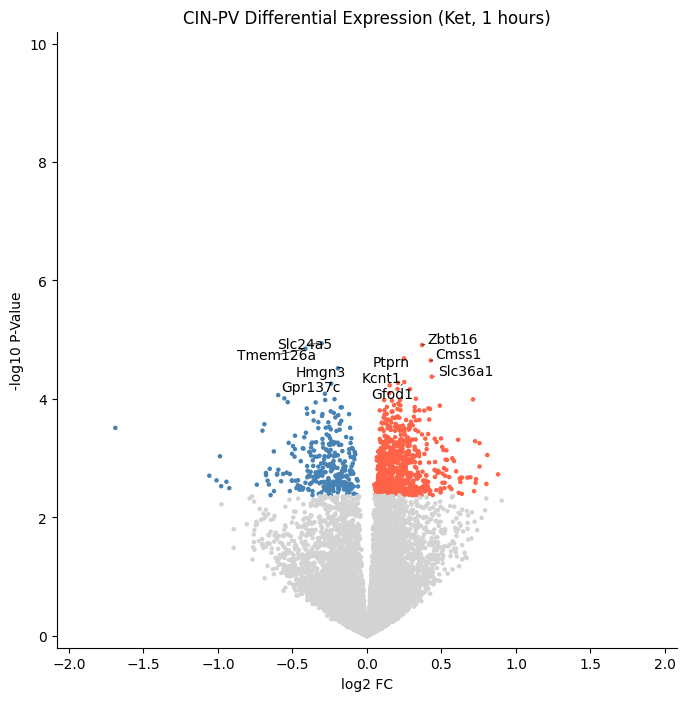

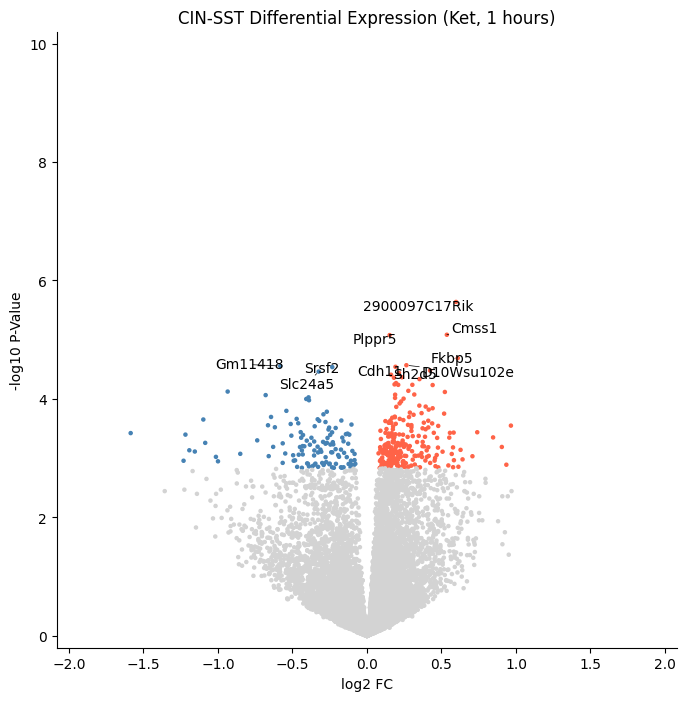

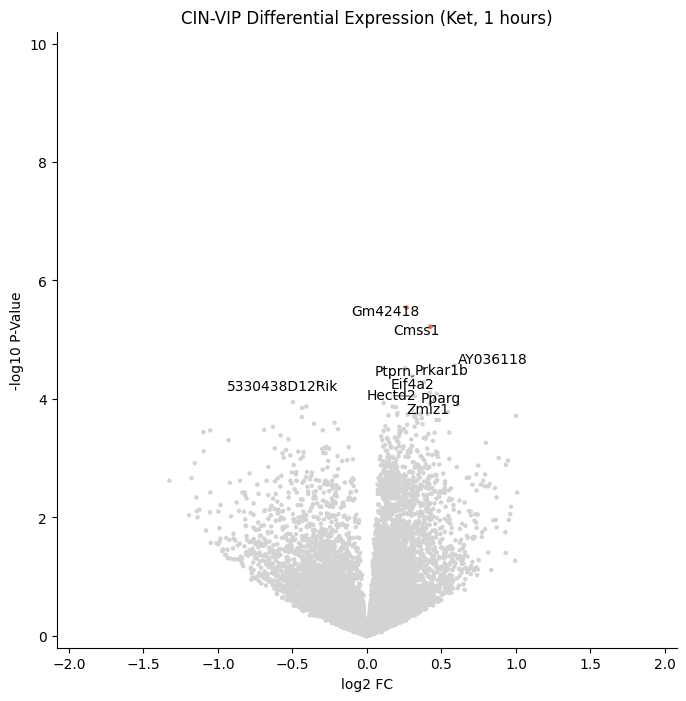

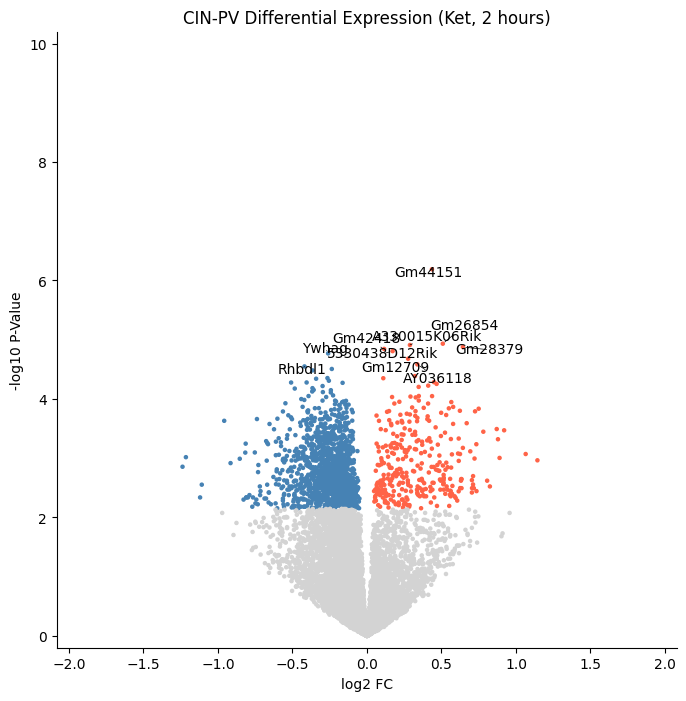

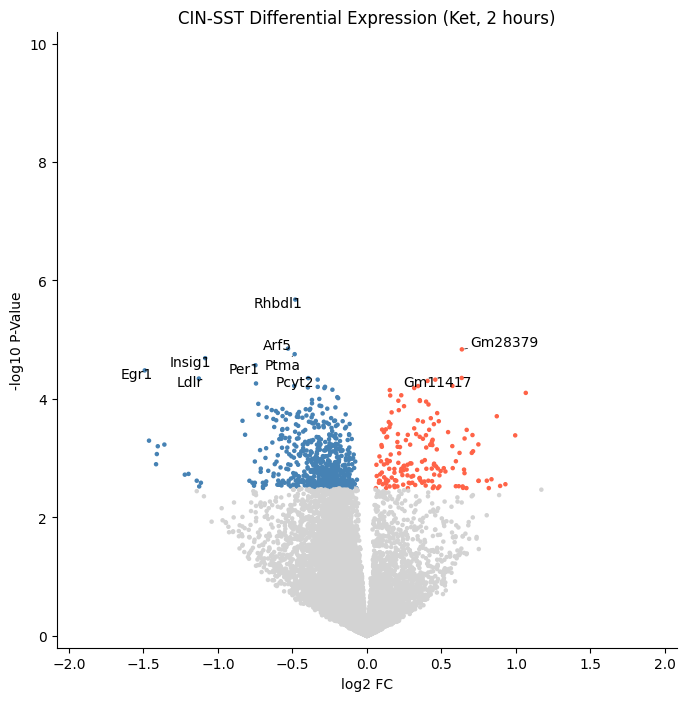

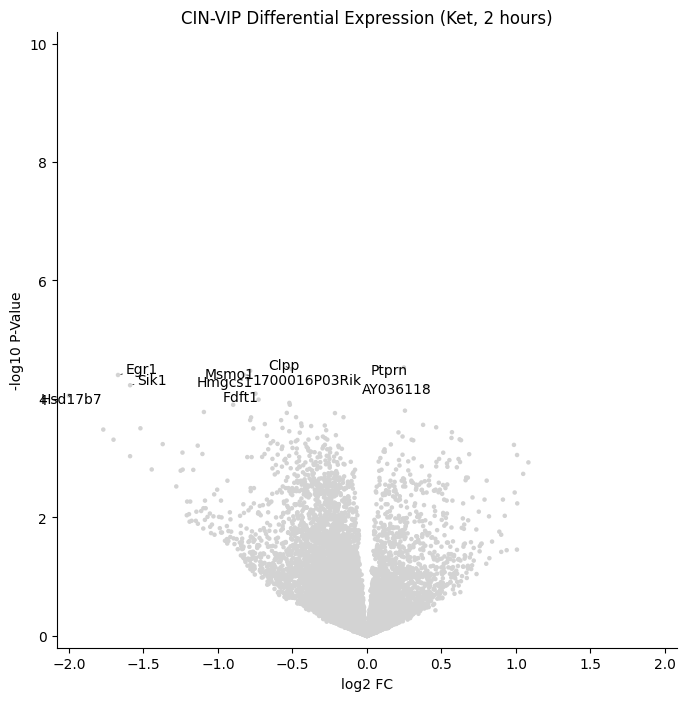

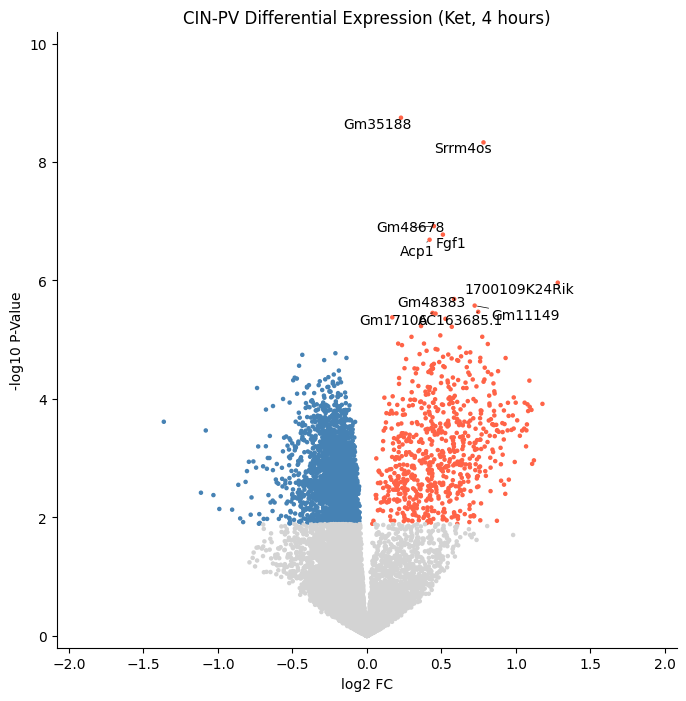

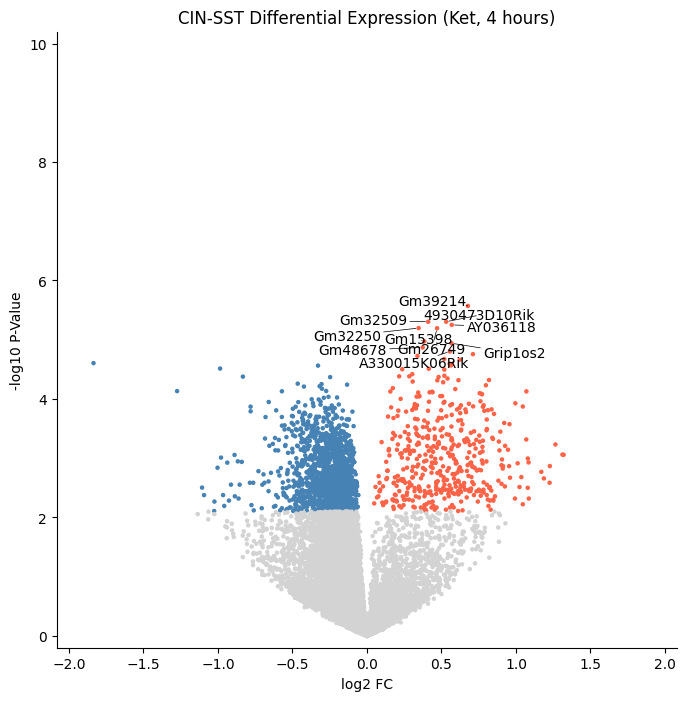

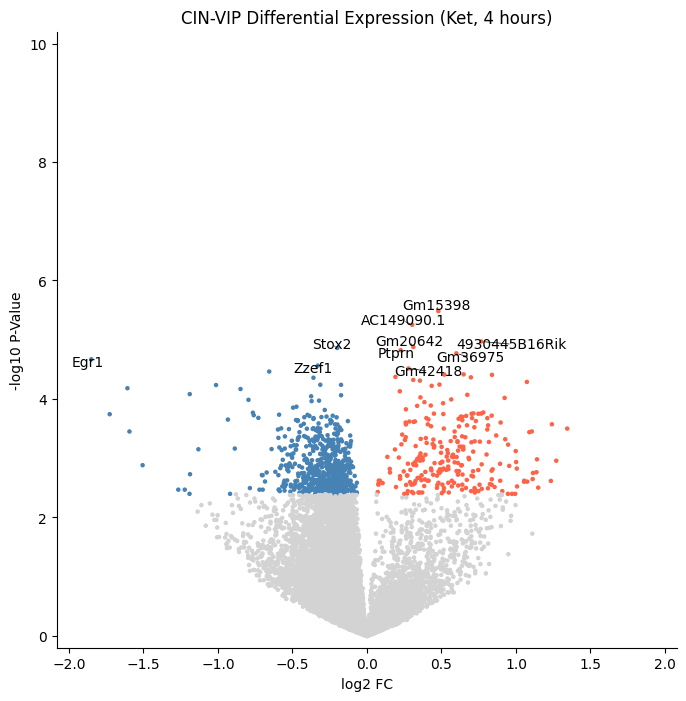

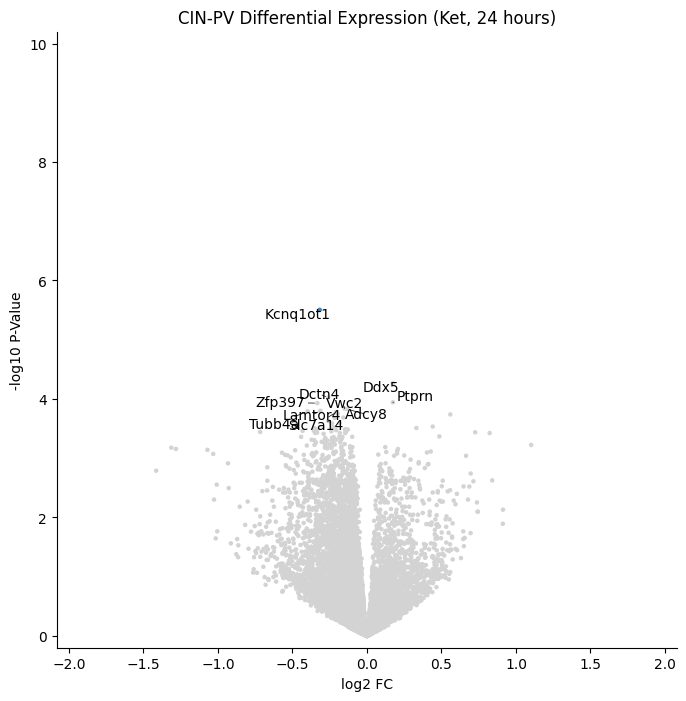

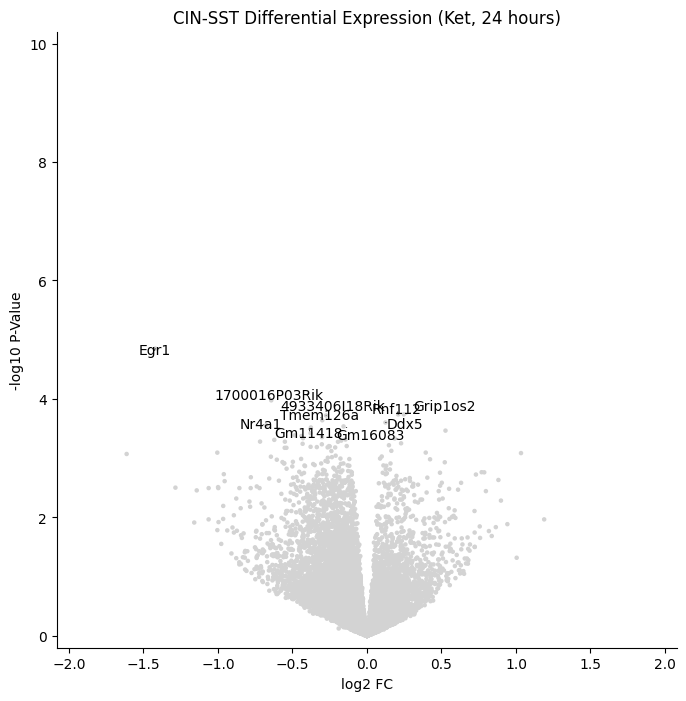

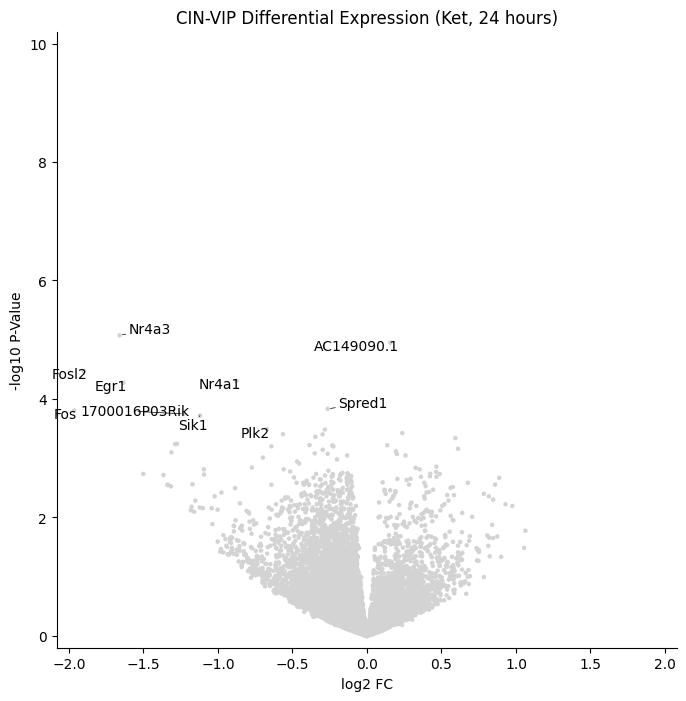

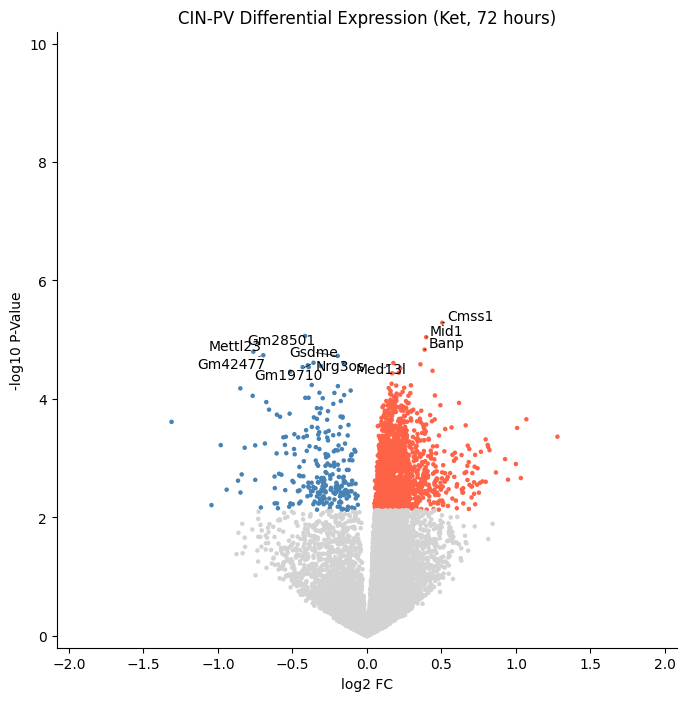

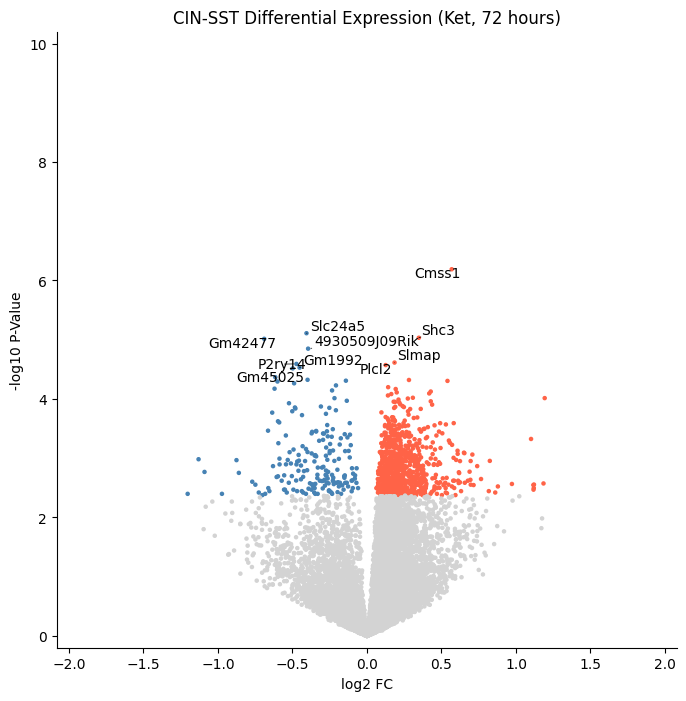

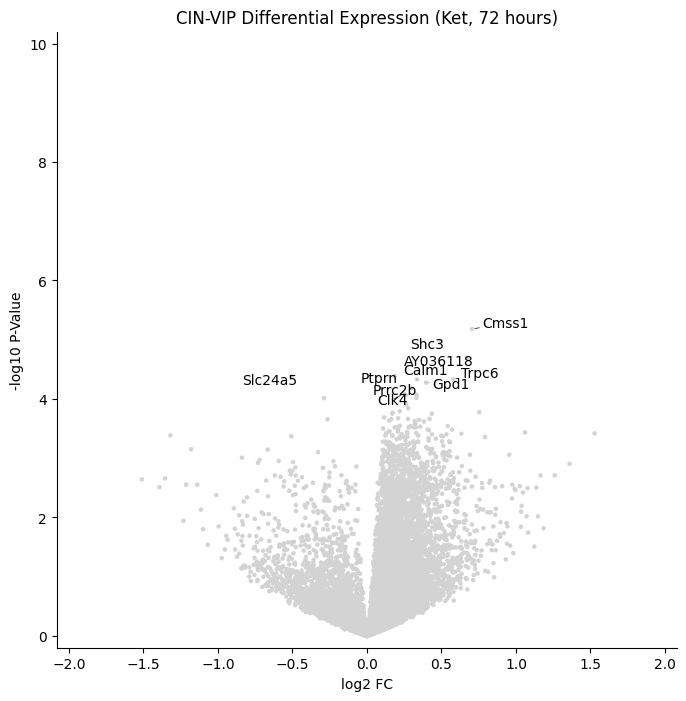

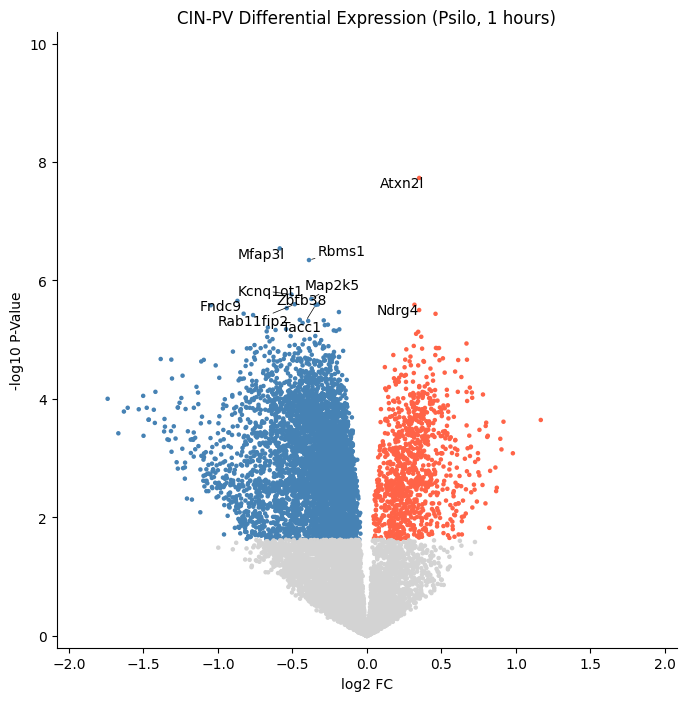

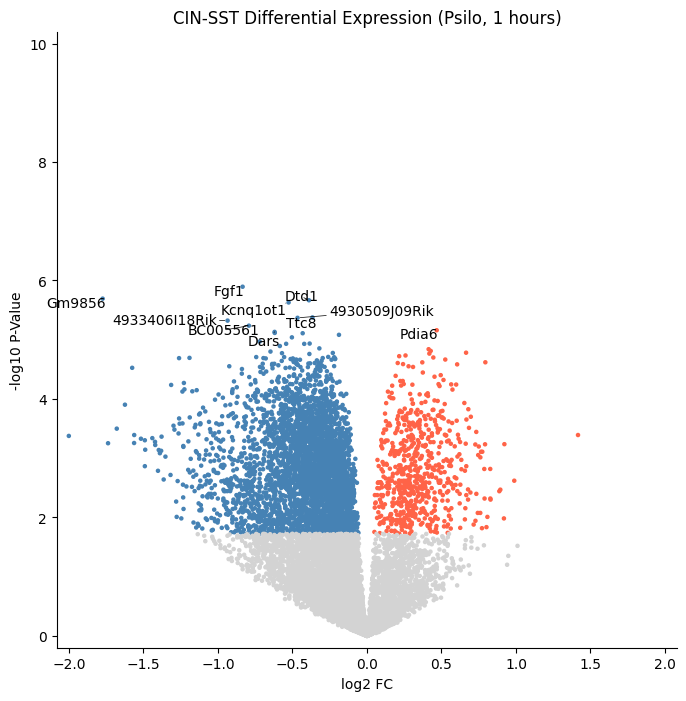

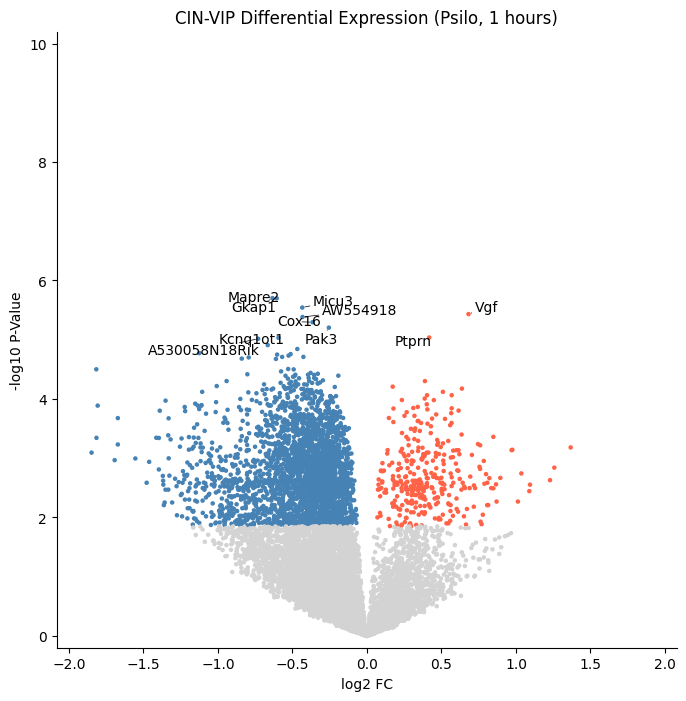

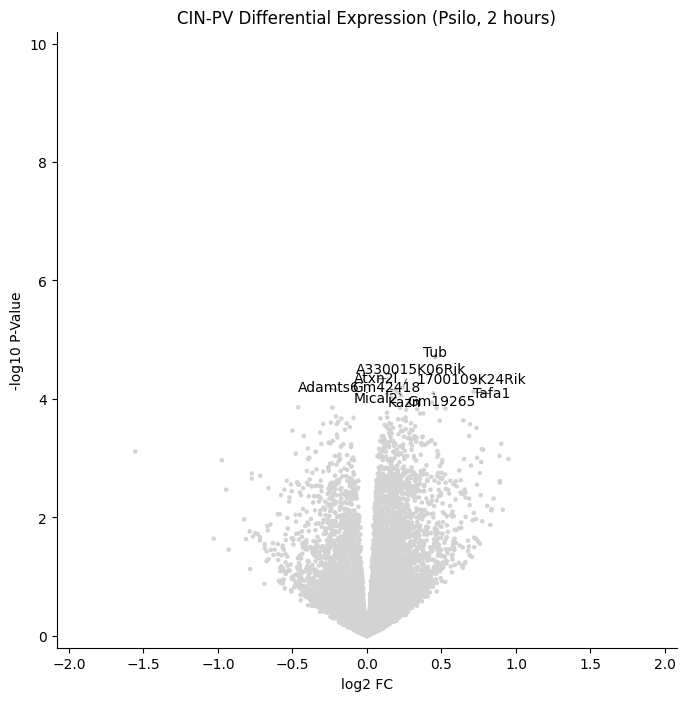

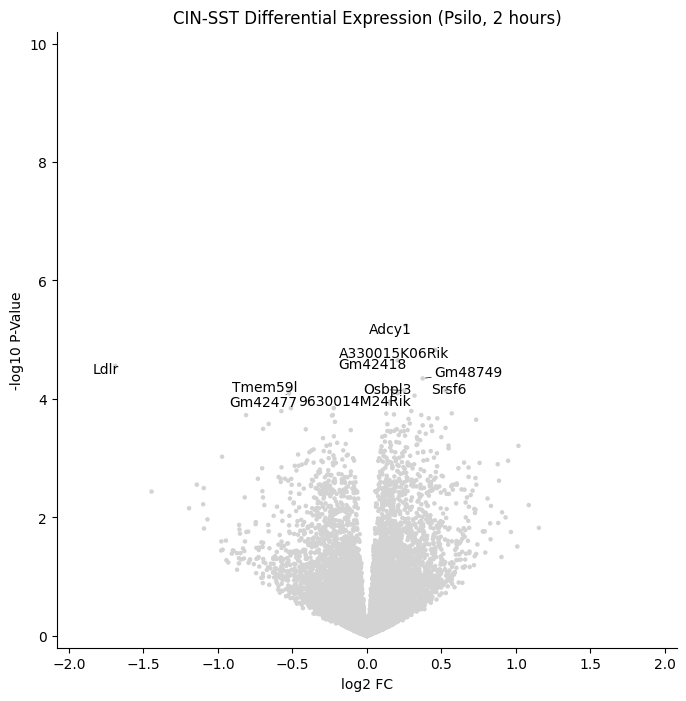

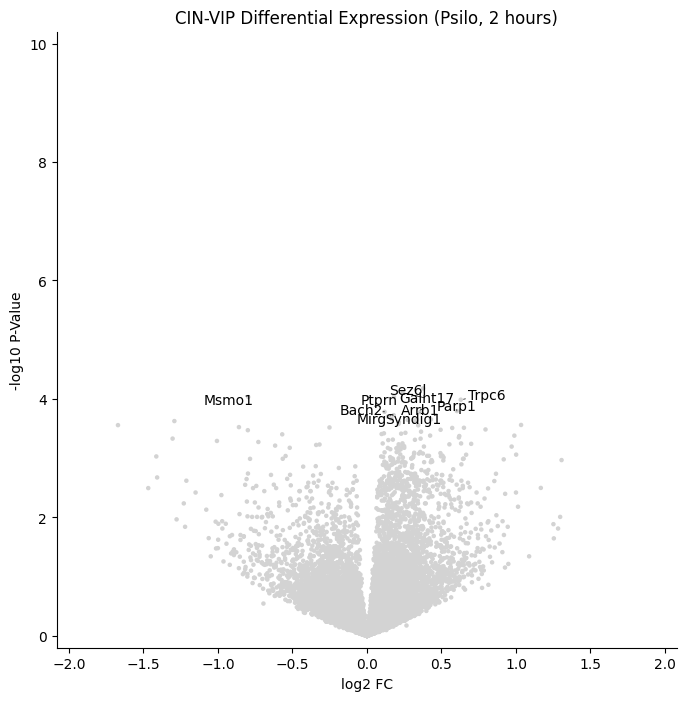

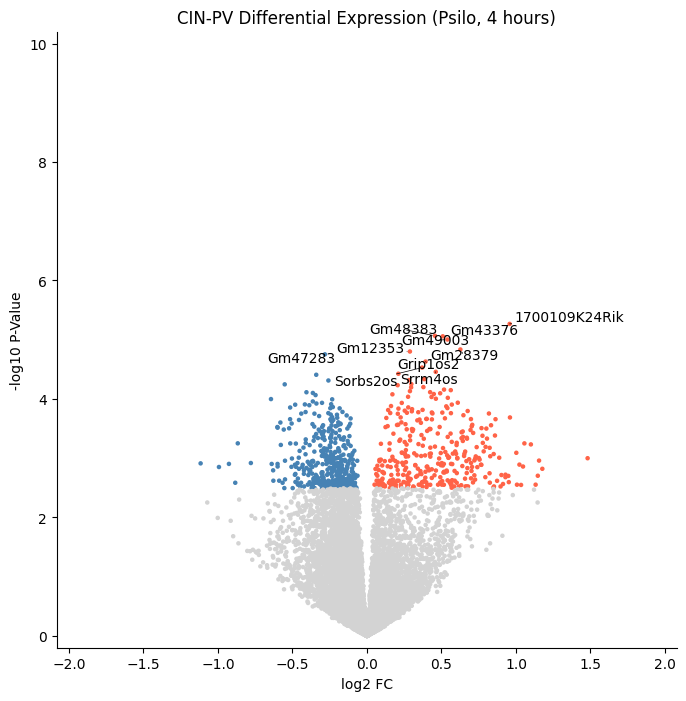

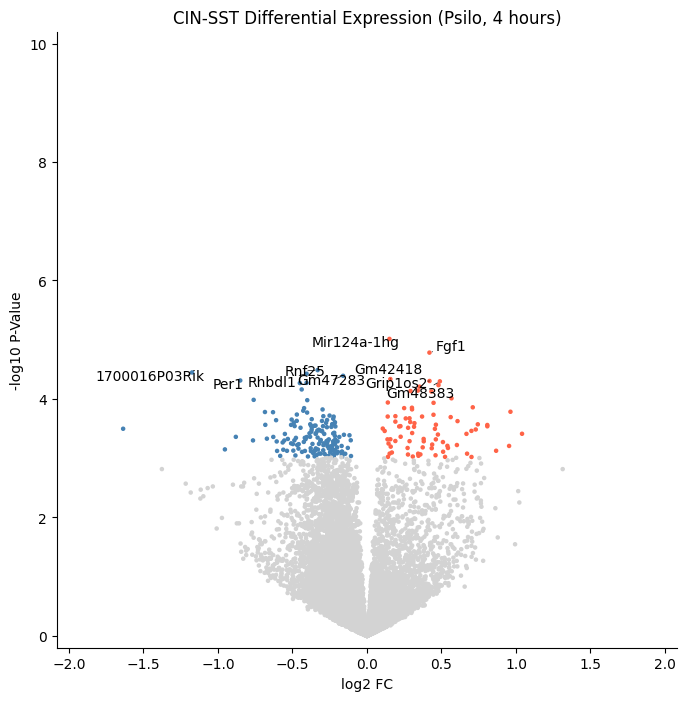

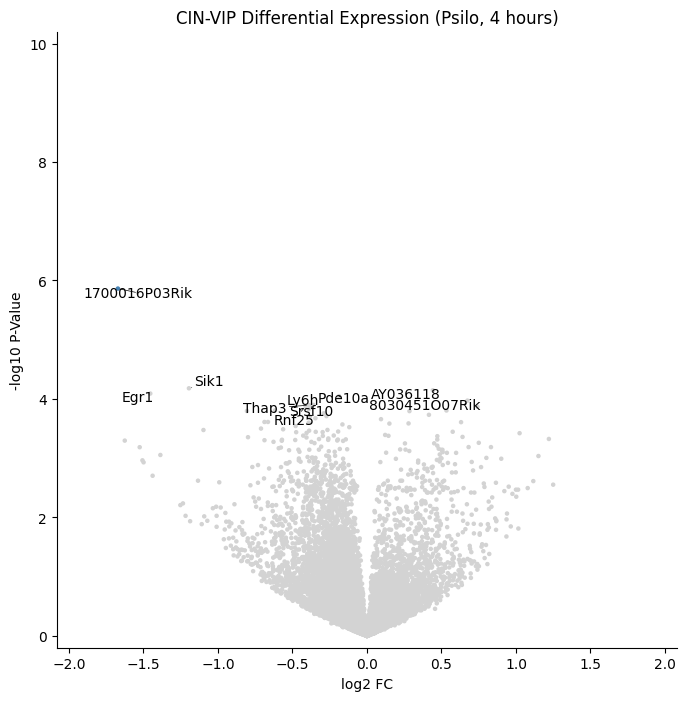

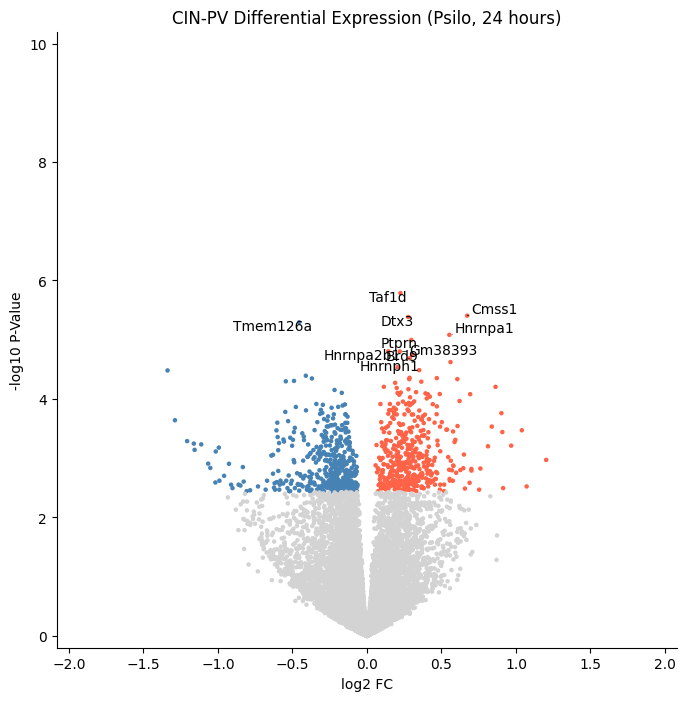

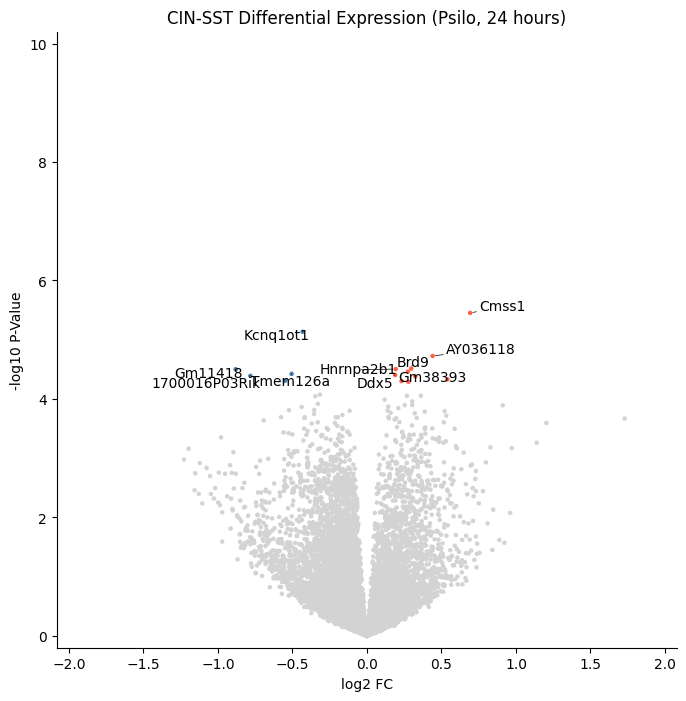

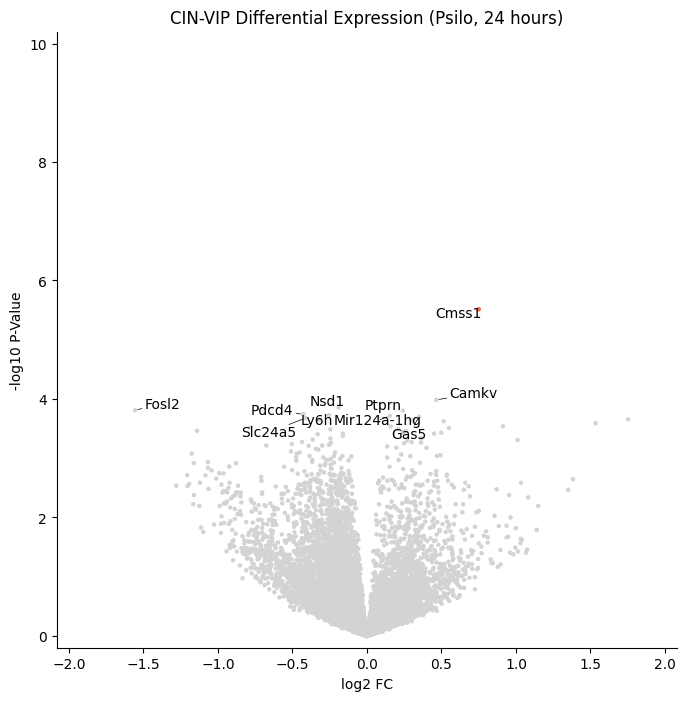

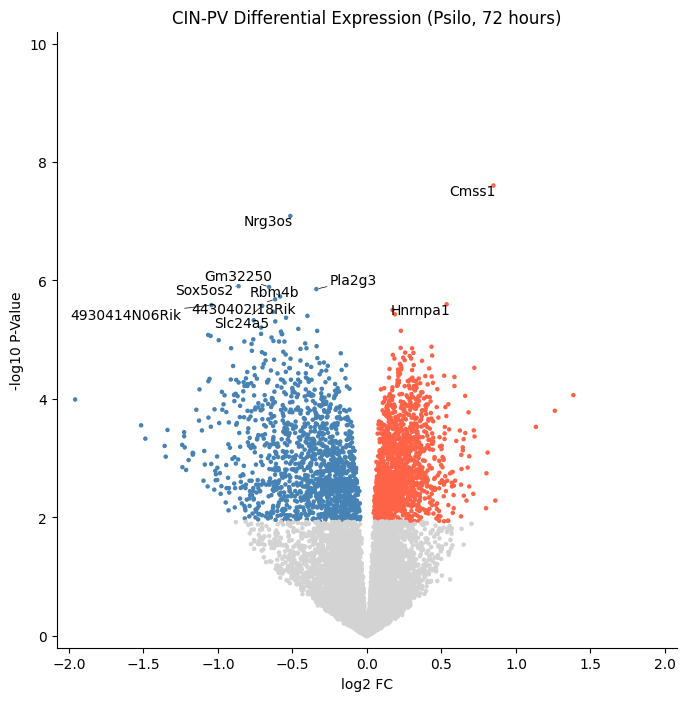

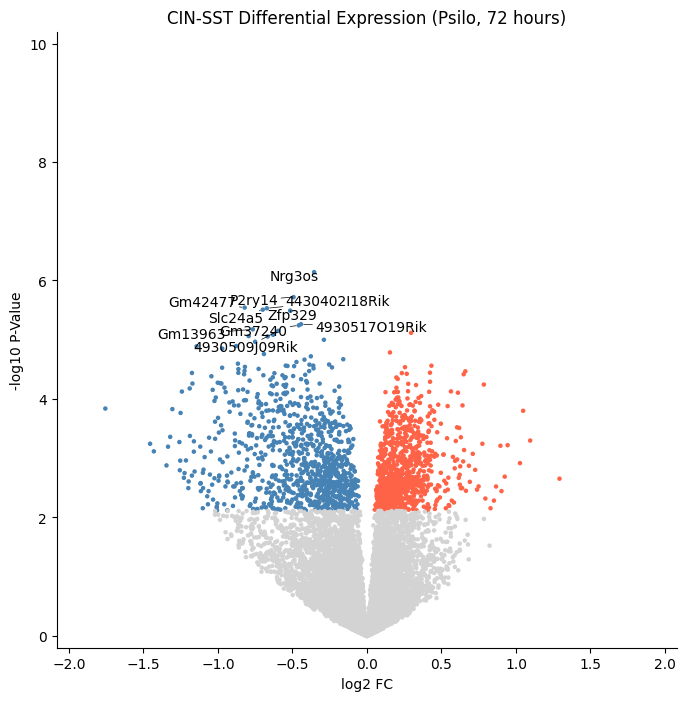

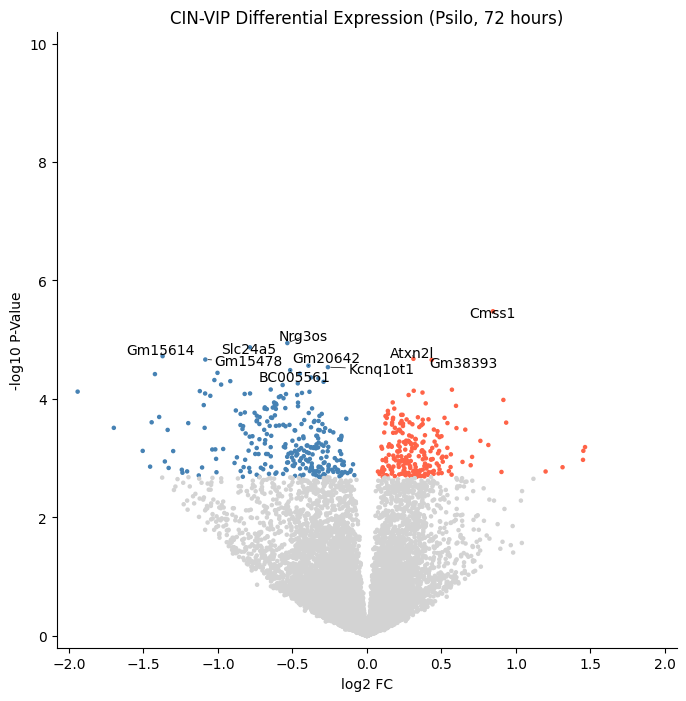

In [83]:
for (drug, time) in itertools.product(trt_drugs, trt_times):
    for cluster,cluster_name in zip(['8','10','12'], ['CIN-PV', 'CIN-SST', 'CIN-VIP']):
        print(drug, time, cluster, cluster_name)
        df = memento_full[(memento_full['drug'] == drug) &
                           (memento_full['time'] == time) &
                            (memento_full['cluster'] == cluster)].copy()
        
        fig, ax = plt.subplots(1,1,figsize=(8,8))
        make_volcano(df, ax, title=f"{cluster_name} Differential Expression ({drug}, {time} hours)", ymax=10)
        fig.savefig(f"{this_figure_dir}/{cluster_name}_volcano_{drug}_{time}.png")
        fig.savefig(f"{this_figure_dir}/{cluster_name}_volcano_{drug}_{time}.pdf")

In [84]:
sorted(os.listdir(this_figure_dir))

['CIN-PV_volcano_Ket_1.pdf',
 'CIN-PV_volcano_Ket_1.png',
 'CIN-PV_volcano_Ket_2.pdf',
 'CIN-PV_volcano_Ket_2.png',
 'CIN-PV_volcano_Ket_24.pdf',
 'CIN-PV_volcano_Ket_24.png',
 'CIN-PV_volcano_Ket_4.pdf',
 'CIN-PV_volcano_Ket_4.png',
 'CIN-PV_volcano_Ket_72.pdf',
 'CIN-PV_volcano_Ket_72.png',
 'CIN-PV_volcano_Psilo_1.pdf',
 'CIN-PV_volcano_Psilo_1.png',
 'CIN-PV_volcano_Psilo_2.pdf',
 'CIN-PV_volcano_Psilo_2.png',
 'CIN-PV_volcano_Psilo_24.pdf',
 'CIN-PV_volcano_Psilo_24.png',
 'CIN-PV_volcano_Psilo_4.pdf',
 'CIN-PV_volcano_Psilo_4.png',
 'CIN-PV_volcano_Psilo_72.pdf',
 'CIN-PV_volcano_Psilo_72.png',
 'CIN-SST_volcano_Ket_1.pdf',
 'CIN-SST_volcano_Ket_1.png',
 'CIN-SST_volcano_Ket_2.pdf',
 'CIN-SST_volcano_Ket_2.png',
 'CIN-SST_volcano_Ket_24.pdf',
 'CIN-SST_volcano_Ket_24.png',
 'CIN-SST_volcano_Ket_4.pdf',
 'CIN-SST_volcano_Ket_4.png',
 'CIN-SST_volcano_Ket_72.pdf',
 'CIN-SST_volcano_Ket_72.png',
 'CIN-SST_volcano_Psilo_1.pdf',
 'CIN-SST_volcano_Psilo_1.png',
 'CIN-SST_volcano_Psilo_

## Try again with edger

In [85]:
os.makedirs(os.path.join(this_figure_dir, 'pseudobulk_clusters_counts'), exist_ok=True)

In [86]:
sample_metadata.shape

(42, 4)

In [87]:
CIN_pseudobulk_metadata = sample_metadata.merge(pd.DataFrame({'cluster':['8','10','12']}), how='cross')

In [88]:
cluster_lookup[cluster_lookup['id'].isin(['8','10','12'])]

id     name    color
11  12  CIN-VIP  #648FFF
8    8   CIN-PV  #B00B00
10  10  CIN-SST  #FE6100

### separate CIN VIP, SST, and PV

In [89]:
# CIN_pseudobulk_metadata = sample_metadata.merge(pd.DataFrame({'cluster':['8','10','12']}), how='cross')
CIN_pseudobulk_metadata = sample_metadata.merge(cluster_lookup[cluster_lookup['id'].isin(['8','10','12'])], how='cross')
CIN_pseudobulk_metadata['filepath'] = CIN_pseudobulk_metadata.apply(
    lambda row: os.path.join(this_figure_dir, 'pseudobulk_clusters_counts', 'cluster_{cluster}_{label}.tsv').format(
        cluster = row['id'],
        label = row['label'],
    ),
    axis=1
)
CIN_pseudobulk_metadata.to_csv(os.path.join(this_figure_dir, 'pseudobulk_clusters_counts', 'pseudobulk_metadata.csv'), index=False)
CIN_pseudobulk_metadata.head()

Drug Timepoint     Seq ID          label  id     name    color  \
0  none        0h  6155-CL-1  0h_none_F_346  12  CIN-VIP  #648FFF   
1  none        0h  6155-CL-1  0h_none_F_346   8   CIN-PV  #B00B00   
2  none        0h  6155-CL-1  0h_none_F_346  10  CIN-SST  #FE6100   
3  none        0h  6128-CL-1  0h_none_F_347  12  CIN-VIP  #648FFF   
4  none        0h  6128-CL-1  0h_none_F_347   8   CIN-PV  #B00B00   

                                            filepath  
0  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
1  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
2  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
3  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
4  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...

In [90]:
for index, row in CIN_pseudobulk_metadata.iterrows():
    cluster = row['id']
    label = row['label']
    drug = row['Drug']
    filepath = row['filepath']
    
    cdata = rna_data[(rna_data.obs['leiden'] == cluster) &
                    (rna_data.obs['label'] == label)].copy()
    pseudobulk_matrix = cdata.X.todense().astype(int).sum(axis=0)
    pseudobulk = np.squeeze(np.asarray(pseudobulk_matrix))
    counts_tsv = pd.Series(pseudobulk, index=cdata.var.index)
    counts_tsv.to_csv(filepath, sep='\t')

### lump all CIN

In [91]:
CIN_lump_pseudobulk_metadata = sample_metadata.copy()
CIN_lump_pseudobulk_metadata['filepath'] = CIN_lump_pseudobulk_metadata.apply(
    lambda row: os.path.join(this_figure_dir, 'pseudobulk_clusters_counts', 'cluster_{cluster}_{label}.tsv').format(
        cluster = 'CIN_lump',
        label = row['label'],
    ),
    axis=1
)
CIN_lump_pseudobulk_metadata.to_csv(
    os.path.join(this_figure_dir, 'pseudobulk_clusters_counts', 'lump_pseudobulk_metadata.csv'), 
    index=False)
CIN_lump_pseudobulk_metadata.head()

Drug Timepoint     Seq ID          label  \
0  none        0h  6155-CL-1  0h_none_F_346   
1  none        0h  6128-CL-1  0h_none_F_347   
2  none        0h  6881-CL-1  0h_none_F_465   
3  none        0h  6881-CL-2  0h_none_F_467   
5  none        0h  5889-CL-1  0h_none_M_291   

                                            filepath  
0  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
1  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
2  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
3  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...  
5  /nfs/turbo/umms-kykwan/projects/alex_kwan/pape...

In [92]:
for index, row in CIN_lump_pseudobulk_metadata.iterrows():
    cluster_name = 'CIN_lump'
    label = row['label']
    drug = row['Drug']
    filepath = row['filepath']
    
    cdata = rna_data[(rna_data.obs['leiden'].isin(['8','10','12'])) &
                    (rna_data.obs['label'] == label)].copy()
    pseudobulk_matrix = cdata.X.todense().astype(int).sum(axis=0)
    pseudobulk = np.squeeze(np.asarray(pseudobulk_matrix))
    counts_tsv = pd.Series(pseudobulk, index=cdata.var.index)
    counts_tsv.to_csv(filepath, sep='\t')

In [93]:
len(sorted(os.listdir(os.path.join(this_figure_dir, 'pseudobulk_clusters_counts'))))

290

# Figure 6 (formerly 7)

1.	Create 2 pairwise comparisons of Cosine Similarity of DEGs between timepoints, using 1 hour timepoint as reference – y-axis would be cosine similarity of DEG of current time with DEG at 1 hr, x-axis would be time points (2, 4, 24, 72 hr). There will be 2 plots, for ket and psi. Each plot will have 5 lines, one for each of ET, IT, SST, PV, VIP.
-	Get 95% CI with bootstrapping and plot error bars 
-	Make range of y-axis from -1 to +1


In [94]:
this_figure_dir = f'{settings.fig_path}/figure_6'
os.makedirs(this_figure_dir, exist_ok=True)

In [95]:
cluster_lookup

id              name    color
1    1             L6-CT  #A9CFA4
7    7             L5-PT  #F4C700
2    2           L4/5-IT  #8650F5
3    3             L4-IT  #8650F5
0    0           L2/3-IT  #8650F5
5    5           L5/6-IT  #8650F5
11  12           CIN-VIP  #648FFF
8    8            CIN-PV  #B00B00
10  10           CIN-SST  #FE6100
4    4  Oligodendrocytes  #A3B5CC
6    6        Astrocytes  #D8A4C7
9    9               OPC  #A8DADC

In [96]:
trt_drugs = drugs[1:]
trt_times = times[1:]
print(len(list(itertools.product(trt_drugs,clusters,trt_times))))
trt_drugs,clusters,trt_times

120


(['Ket', 'Psilo'],
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '12'],
 array([ 1,  2,  4, 24, 72]))

## The plan

10 lines need to be made in total.

2 lines from the IT lump need to come from the adhoc memento results in figure 5

the other 8 can come from the memento_full data

In [97]:
lines = []

### The Rest

In [106]:
for drug in trt_drugs:
    for time in trt_times[1:]: # exclude 1 bc thats the DEG reference
        for cluster in ['L5-PT','CIN-VIP','CIN-PV','CIN-SST']:
            try:
                A = de_overlaps_1000[drug,cluster,time]
                B = de_overlaps_1000[drug,cluster,1]
                similarity = cosine_similarity(A, B)
            except KeyError:
                similarity = 0
            lines.append({
                'drug':drug,
                'time':time,
                'cluster':cluster,
                'similarity':similarity,
            })

### IT

In [107]:
memento_IT.head(1)

gene  initial_de  initial_de_pval  initial_de_padj drug  time
0  Lpgat1    0.123609     1.527522e-10         0.000002  Ket     1

In [108]:
de_overlaps_1000_IT_lump = memento_IT.copy()
de_overlaps_1000_IT_lump = de_overlaps_1000_IT_lump[['gene','drug','time','initial_de','initial_de_padj']]
de_overlaps_1000_IT_lump_groups = de_overlaps_1000_IT_lump.groupby(['drug','time']) 
de_overlaps_1000_IT_lump = {}
for name, group in de_overlaps_1000_IT_lump_groups:
    de_overlaps_1000_IT_lump[name] = group.sort_values('initial_de_padj', ascending=True) \
         .reset_index() \
         .loc[0:999]
    
del de_overlaps_1000_IT_lump_groups
de_overlaps_1000_IT_lump[('Ket',1)]

index     gene drug  time  initial_de  initial_de_padj
0        0   Lpgat1  Ket     1    0.123609         0.000002
1        1      Mkx  Ket     1   -0.108052         0.000013
2        2   Lrrc49  Ket     1    0.152214         0.000016
3        3     Tesc  Ket     1    0.220526         0.000016
4        4   Mapk11  Ket     1    0.208848         0.000023
..     ...      ...  ...   ...         ...              ...
995    995    Casd1  Ket     1    0.153722         0.000703
996    996  Ceacam2  Ket     1   -0.348825         0.000703
997    997    Tmtc1  Ket     1   -0.059264         0.000705
998    998     Taf7  Ket     1   -0.396591         0.000706
999    999    Eif3b  Ket     1    0.205176         0.000706

[1000 rows x 6 columns]

In [109]:
de_overlaps_significant_IT_lump = memento_IT.copy()
de_overlaps_significant_IT_lump = de_overlaps_significant_IT_lump[['gene','drug','time','initial_de','initial_de_padj']]
de_overlaps_significant_IT_lump_groups = de_overlaps_significant_IT_lump.groupby(['drug','time']) 
de_overlaps_significant_IT_lump = {}
for name, group in de_overlaps_significant_IT_lump_groups:
    de_overlaps_significant_IT_lump[name] = group.sort_values('initial_de_padj', ascending=True) \
         .reset_index() \
         .query('initial_de_padj < 0.05')
    
del de_overlaps_significant_IT_lump_groups
de_overlaps_significant_IT_lump[('Ket',1)].shape[0]

7554

In [110]:
for drug in trt_drugs:
    for time in trt_times[1:]: # exclude 1 bc thats the DEG reference
        try:
            A = de_overlaps_1000_IT_lump[drug,time]
            B = de_overlaps_1000_IT_lump[drug,1]
            similarity = cosine_similarity(A, B)
        except KeyError:
            similarity = 0
        lines.append({
            'drug':drug,
            'time':time,
            'cluster':'IT',
            'similarity':similarity,
        })

In [111]:
lines_df = pd.DataFrame(lines)
lines_df['time'] = lines_df['time'].astype(str)
lines_df

drug time  cluster  similarity
0     Ket    2    L5-ET    0.000000
1     Ket    2  CIN-VIP    0.197575
2     Ket    2   CIN-PV    0.165509
3     Ket    2  CIN-SST    0.179614
4     Ket    4    L5-ET    0.000000
..    ...  ...      ...         ...
75    Ket   72       IT    0.446803
76  Psilo    2       IT    0.150857
77  Psilo    4       IT    0.046002
78  Psilo   24       IT    0.252046
79  Psilo   72       IT    0.303394

[80 rows x 4 columns]

In [114]:
cluster_colors = colors_19[0:5]
color_order = ['L5-PT','IT','CIN-PV','CIN-SST','CIN-VIP']

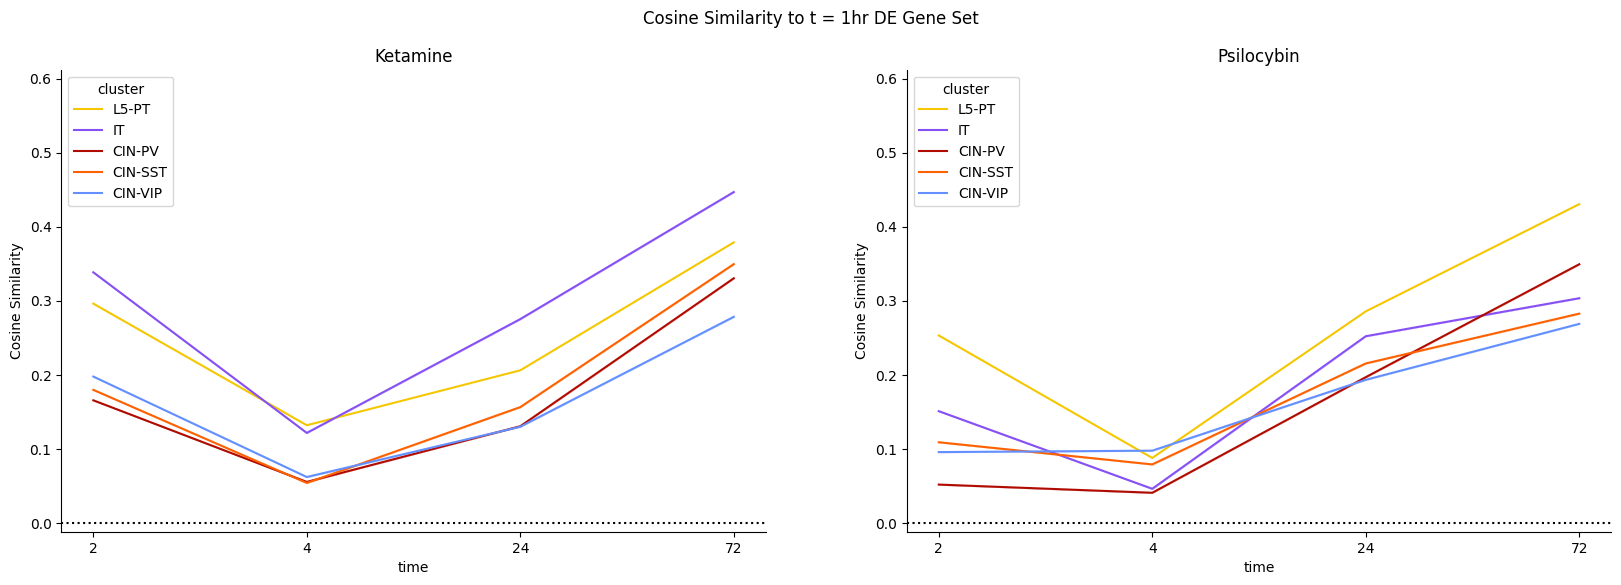

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))

sns.lineplot(
    data=lines_df.query('drug == "Ket"'),
    x='time', y='similarity', hue='cluster',
    palette=cluster_colors, hue_order=color_order,
    ax=axes[0],
)
axes[0].set_title('Ketamine')

sns.lineplot(
    data=lines_df.query('drug == "Psilo"'),
    x='time', y='similarity', hue='cluster',
    palette=cluster_colors, hue_order=color_order,
    ax=axes[1],
)
axes[1].set_title('Psilocybin')

for ax in axes:
    ax.set(ylim=extend_limits((0,0.6)), ylabel='Cosine Similarity',)
    ax.axhline(0, color='black', linestyle='dotted')
sns.despine(fig=fig)
fig.suptitle('Cosine Similarity to t = 1hr DE Gene Set')

fig.savefig(f"{this_figure_dir}/timecourse_similarity_line.png")
fig.savefig(f"{this_figure_dir}/timecourse_similarity_line.pdf")

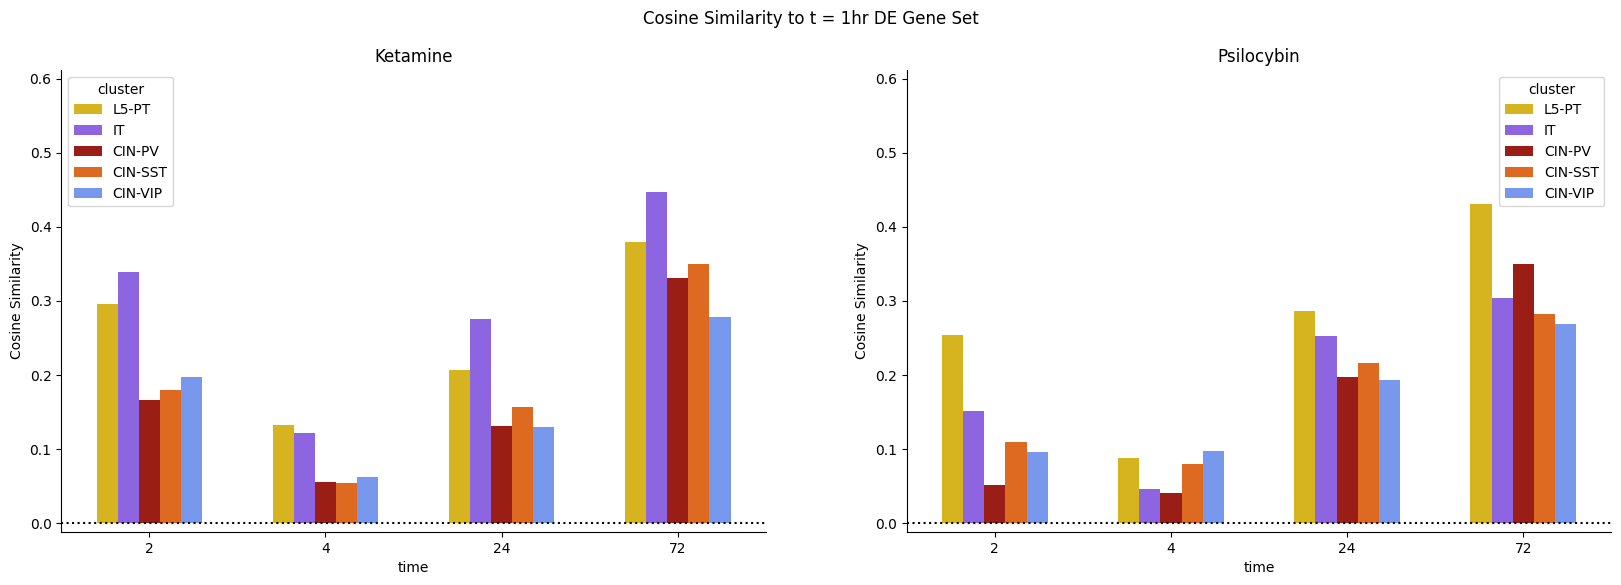

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))
BAR_WIDTH = 0.6

sns.barplot(
    data=lines_df.query('drug == "Ket"'),
    x='time', y='similarity', hue='cluster',
    palette=cluster_colors, hue_order=color_order,
    width=BAR_WIDTH,
    ax=axes[0],
)
axes[0].set_title('Ketamine')

sns.barplot(
    data=lines_df.query('drug == "Psilo"'),
    x='time', y='similarity', hue='cluster',
    palette=cluster_colors, hue_order=color_order,
    width=BAR_WIDTH,
    ax=axes[1],
)
axes[1].set_title('Psilocybin')

for ax in axes:
    ax.set(ylim=extend_limits((0,0.6)), ylabel='Cosine Similarity',)
    ax.axhline(0, color='black', linestyle='dotted')
sns.despine(fig=fig)
fig.suptitle('Cosine Similarity to t = 1hr DE Gene Set')

fig.savefig(f"{this_figure_dir}/timecourse_similarity_bar.png")
fig.savefig(f"{this_figure_dir}/timecourse_similarity_bar.pdf")

# Figure 7 (formerly 8)

8.	Create 5 Interdrug Cosine Similarity graphs, one for each timepoint (1hr, 2hr, 4hr, 24hr, 72hr) 
-	Get 95% CI with bootstrapping and plot error bars 
-	Make range of y-axis from -1 to +1


In [117]:
this_figure_dir = f'{settings.fig_path}/figure_7'
os.makedirs(this_figure_dir, exist_ok=True)

In [118]:
trt_drugs = drugs[1:]
trt_times = times[1:]
print(len(list(itertools.product(trt_drugs,clusters,trt_times))))
trt_drugs,clusters,trt_times

120


(['Ket', 'Psilo'],
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '12'],
 array([ 1,  2,  4, 24, 72]))

In [119]:
def interdrug_similarity(time, similarity_function):
    heatmap_idx = cluster_lookup['name'].to_list()
    similarities = np.zeros(len(heatmap_idx))
    for j,j_name in enumerate(heatmap_idx):
        try:
            A = de_overlaps_1000[('Ket',j_name, time)]
            B = de_overlaps_1000[('Psilo',j_name, time)]
            similarities[j] = similarity_function(A, B)
        except KeyError:
            similarities[j] = 0
            continue
    return pd.DataFrame({'cluster':heatmap_cluster_labels, 'similarity':similarities})

In [120]:
# assemble table of values
time_specific_interdrug_similarity_dfs = []
for time in trt_times:
    df = interdrug_similarity(time, cosine_similarity)
    df['time'] = time
    time_specific_interdrug_similarity_dfs.append(df)

all_interdrug_similarity_df = pd.concat(time_specific_interdrug_similarity_dfs)
all_interdrug_similarity_df.to_csv(f'{this_figure_dir}/interdrug_similarity_master_table.csv', index=False)

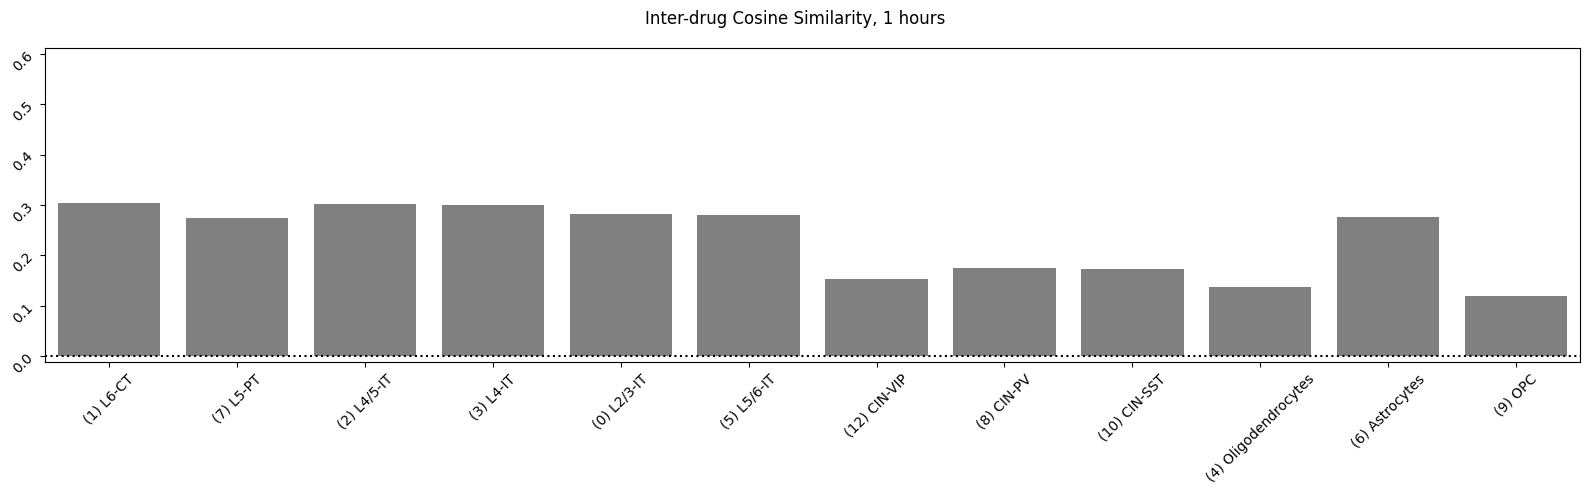

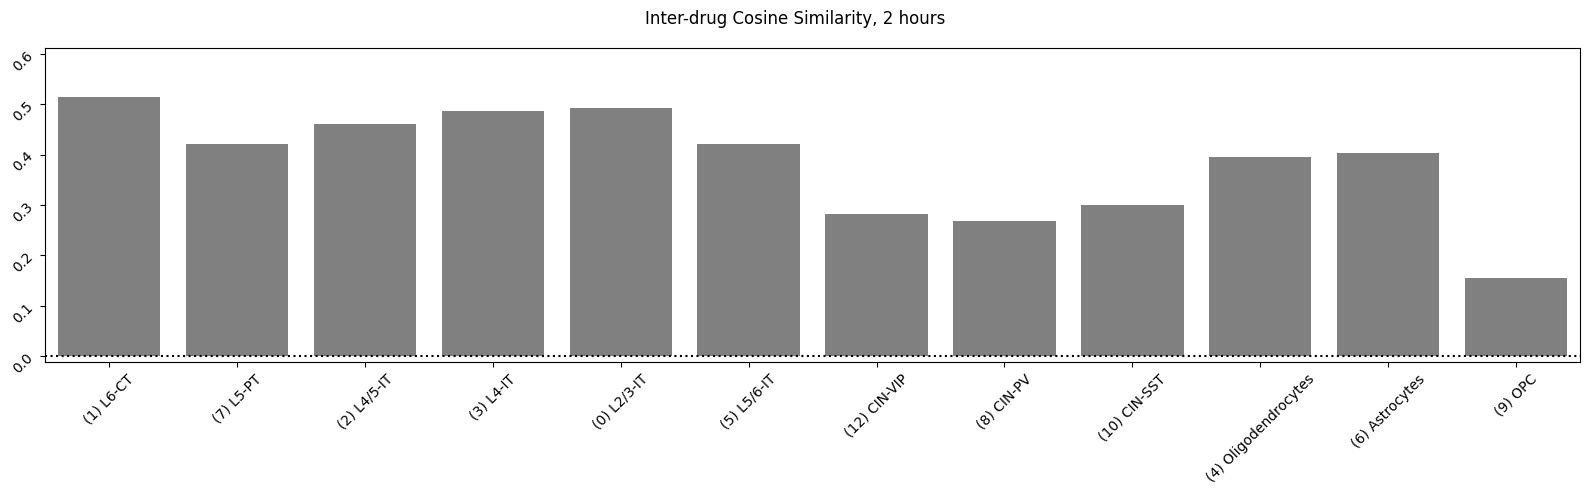

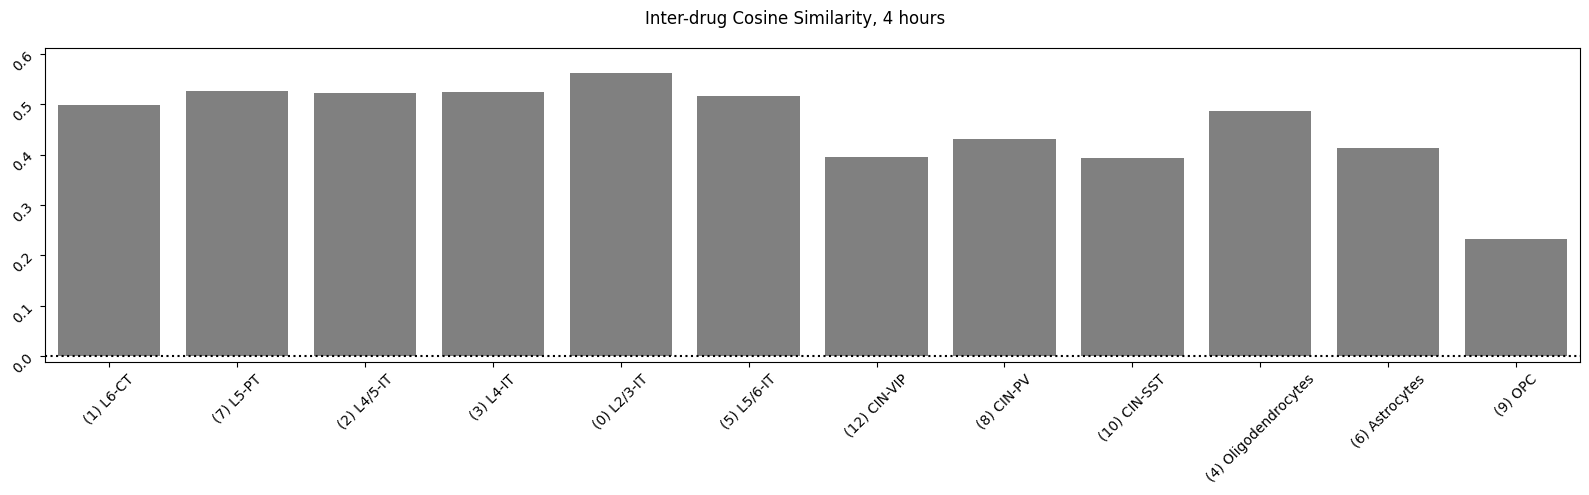

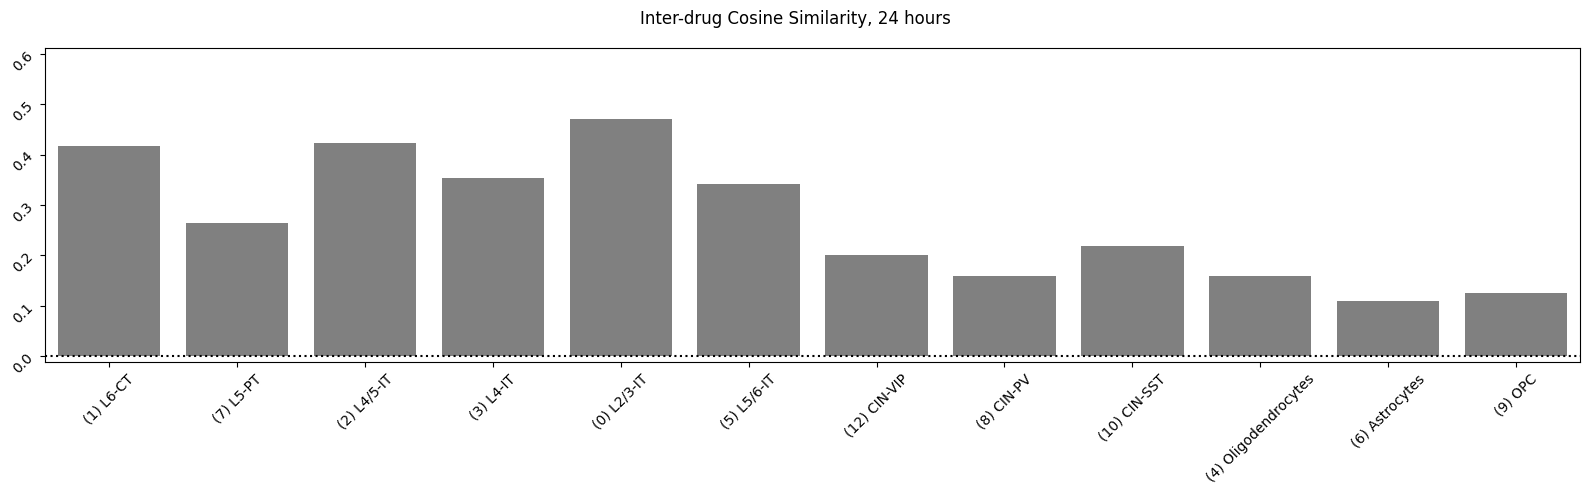

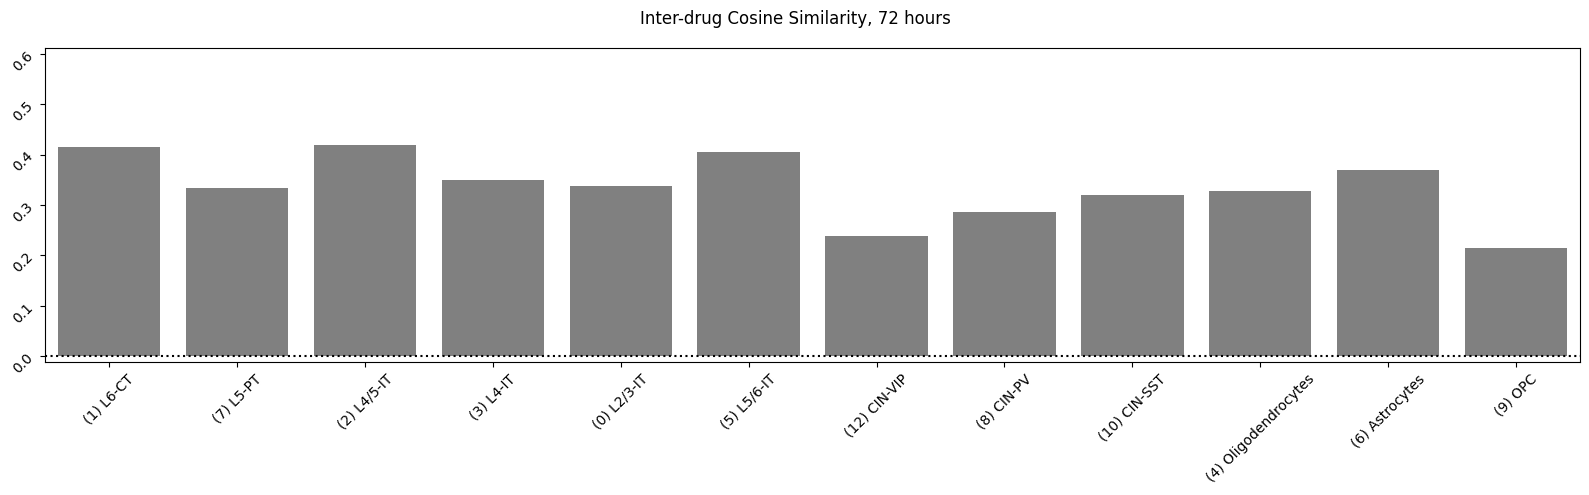

In [121]:
for time in trt_times:
    fig, ax = plt.subplots(figsize=(16, 5))
    sns.barplot(
        data = interdrug_similarity(time, cosine_similarity),
        x = 'cluster', y = 'similarity',
        color = 'grey',
        ax = ax
    )
    ax.axhline(0, linestyle='dotted', color='black',)
    ax.set(xlabel=None, ylabel=None, ylim=extend_limits((0,0.6)))
    ax.tick_params(labelrotation = 45)
    
    fig.suptitle(f'Inter-drug Cosine Similarity, {time} hours')
    fig.tight_layout()
    fig.savefig(f"{this_figure_dir}/interdrug_similarity_{time}hr.png")
    fig.savefig(f"{this_figure_dir}/interdrug_similarity_{time}hr.pdf")

## Revised

See clara's sketch

Best option might be one single df with
- time
- cell type
- num Psilo DE
- num Ket DE
- num shared DE
- interdrug similarity

In [124]:
interdrug_dict = {tup:{} for tup in list(itertools.product(trt_times, ['L5-PT','IT','CIN-PV','CIN-SST','CIN-VIP']))}

for key, data in interdrug_dict.items():
    if 'IT' not in key:
        psilo_set = de_overlaps_significant['Psilo', key[1], key[0]]
        ket_set = de_overlaps_significant['Ket', key[1], key[0]]
    else:
        psilo_set = de_overlaps_significant_IT_lump['Psilo', key[0]]
        ket_set = de_overlaps_significant_IT_lump['Ket', key[0]]
        
    data['num_psilo_DE'] = psilo_set.shape[0]
    data['num_ket_DE'] = ket_set.shape[0]
    data['num_shared_DE'] = psilo_set.merge(ket_set, how='inner', on='gene').shape[0]
    data['similarity'] = cosine_similarity(psilo_set, ket_set)

/tmp/ipykernel_1029417/405953932.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(A_folds, B_folds) / (np.linalg.norm(A_folds) * np.linalg.norm(B_folds))
/tmp/ipykernel_1029417/405953932.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(A_folds, B_folds) / (np.linalg.norm(A_folds) * np.linalg.norm(B_folds))
/tmp/ipykernel_1029417/405953932.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(A_folds, B_folds) / (np.linalg.norm(A_folds) * np.linalg.norm(B_folds))
/tmp/ipykernel_1029417/405953932.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(A_folds, B_folds) / (np.linalg.norm(A_folds) * np.linalg.norm(B_folds))
/tmp/ipykernel_1029417/405953932.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(A_folds, B_folds) / (np.linalg.norm(A_folds) * np.linalg.norm(B_folds))
/tmp/ipykernel_1029417/405953932.py:7: RuntimeWarning: invalid va

In [125]:
interdrug_list = [
    {'time':key[0], 'cluster':key[1], 
     'num_psilo_DE':data['num_psilo_DE'], 'num_ket_DE':data['num_ket_DE'], 
     'num_shared_DE':data['num_shared_DE'], 'similarity':data['similarity']}
    for key,data in interdrug_dict.items()
]
interdrug_df = pd.DataFrame(interdrug_list)
interdrug_df.to_csv(os.path.join(this_figure_dir, 'interdrug_similarity_comprehensive_data.csv'))
interdrug_df.head()

time  cluster  num_psilo_DE  num_ket_DE  num_shared_DE  similarity
0     1    L5-PT          5117        2284           1155    0.275650
1     1       IT         10370        7554           6291    0.487906
2     1   CIN-PV          5611        1018            575    0.177236
3     1  CIN-SST          4475         359            180    0.141267
4     1  CIN-VIP          3199           2              0    0.000000

In [126]:
def myround(x, base=5):
    return base * round(x/base)

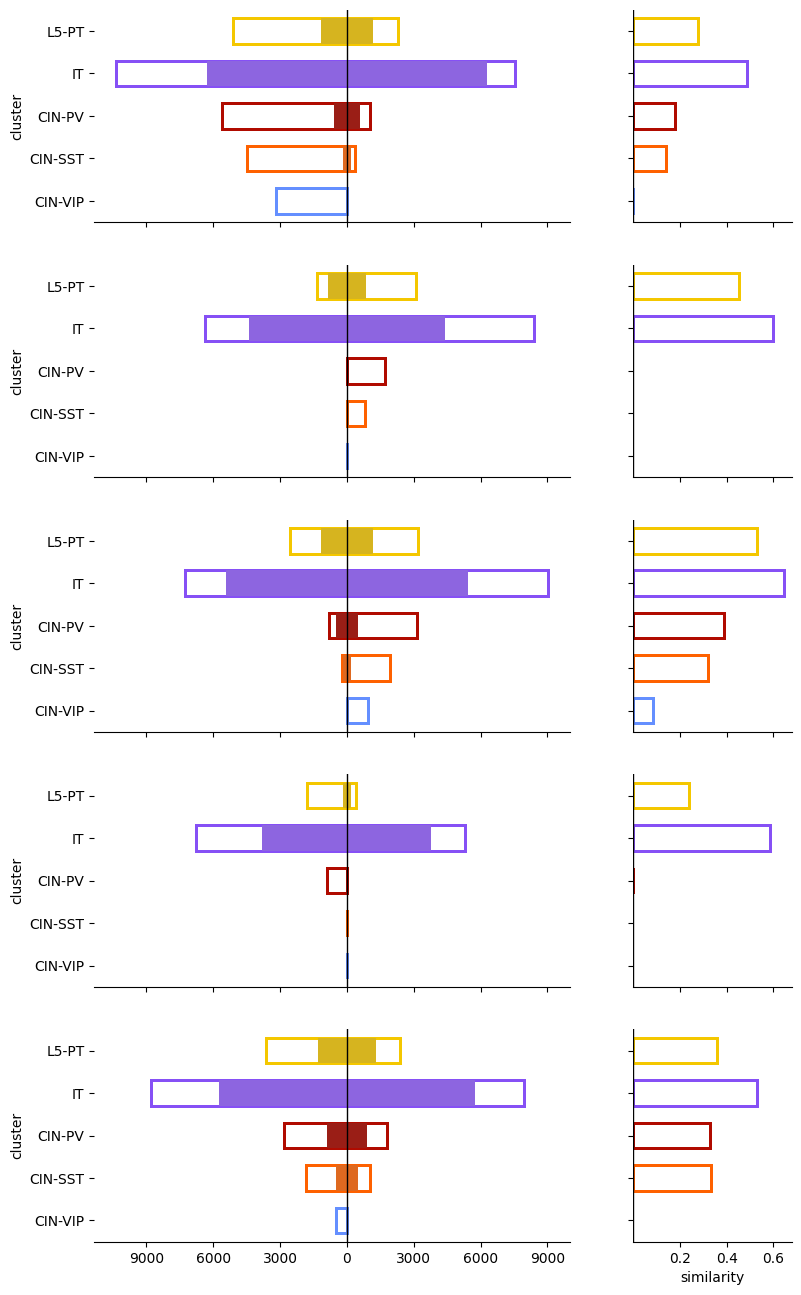

In [127]:
def plot_axis(data, axes_row):
    BAR_WIDTH = 0.6
    LINE_WIDTH = 2.0
    sns.barplot(
        data=data,
        x='num_ket_DE', y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    sns.barplot(
        data=data,
        x = -data['num_psilo_DE'], y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )

    sns.barplot(
        data=data,
        x='num_shared_DE', y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=True, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    sns.barplot(
        data=data,
        x= -data['num_shared_DE'], y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=True, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[0],
    )
    
    sns.barplot(
        data=data,
        x='similarity', y='cluster', hue='cluster',
        palette=cluster_colors, hue_order=color_order,
        fill=False, width=BAR_WIDTH, linewidth=LINE_WIDTH,
        ax=axes_row[1],
    )
    
gs_kw = dict(width_ratios=[3,1],)    
fig, axes = plt.subplots(5, 2, figsize=(9,16), gridspec_kw=gs_kw,
                        sharey='row', sharex='col')
fig.set_facecolor('white')

sns.despine(fig=fig, top=True, right=True, left=True, bottom=False)
for ax in axes.flatten():
    ax.set_xticks([])
    ax.axvline(0, linestyle='-', color='black', linewidth=1)

    for ax_index, time in enumerate(trt_times):
        plot_axis(interdrug_df.query(f'time == {time}'), axes[ax_index])

max_de_size = interdrug_df[['num_psilo_DE','num_ket_DE']].max().max()
de_size_ticks = np.arange(myround(-max_de_size, base=3000), myround(max_de_size, base=3000)+1, 3000)
axes[-1][0].set_xticks(de_size_ticks, labels=np.abs(de_size_ticks))
axes[-1][-1].set_xticks(np.arange(0.2, interdrug_df['similarity'].max(), 0.2))

fig.savefig(f"{this_figure_dir}/interdrug_similarity_comprehensive.png")
fig.savefig(f"{this_figure_dir}/interdrug_similarity_comprehensive.pdf")